# An Analysis of Evidence vs Intuition Rhetoric in US House of Representatives and Constituent Education Levels

We will use SemAxis and BERT to determine how evidence vs intuition-based a sentence is using House of Representative hearings from congress 112-118, then compare these scores to constituents' educational attainment. There are about 5.6 million sentences in our dataset.

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)
pd.set_option('display.max_colwidth', None)
input_path = '/content/drive/MyDrive/ANLP Project/Final_Version/Data/'
intermediate_path = '/content/drive/MyDrive/ANLP Project/Final_Version/Data/Intermediate/'

Mounted at /content/drive


In [ ]:
# !pip install gensim
# !pip install krippendorff
# !pip install pingouin

In [ ]:
# imports

# Standard library
import ast
import os
import pickle
import re
from collections import defaultdict
from typing import Tuple, Dict, Optional

# Third-party data science
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and text processing
import spacy
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

# Machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error
)
from sklearn.model_selection import train_test_split

# Deep learning
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, ttest_rel
import krippendorff
import pingouin as pg
import statsmodels.formula.api as smf

# Progress bar
from tqdm import tqdm

### Data Preparation
1. Load and merge data
- There are 3 datasets:
  - us_census_education_by_district_cleaned.csv
    - PK: state, district, congress
    - Other relevant cols: bachelors_or_higher_percentage
  - house_of_reps.csv
    - PK: state, district, congress
    - Other relevant cols: party, bioname
  - transcripts.csv
    - Merge cols: state, congress, first_name, last_name
    - Other relevant cols: dialogue
- Merge education and house of reps datasets using cols state, district, congress
- Extract first_name and last_name from bioname
- Merge this with transcript data using state, congress, first_name, last_name
- The final output should be a DF called `df_with_names` with cols:
  - `first_name`
  - `last_name`
  - `state`
  - `party`
  - `congress`
  - `district`
  - `dialogue` (one sentence)
  - `bachelors_or_higher_percentage`


Load and clean up the 3 datasets.

Clean up edu dataset. It contains a bachelors or higher percentage by year, but it should be aggregated (mean) by congress.

In [ ]:
# load education data
edu = pd.read_csv(input_path + 'us_census_education_by_district_cleaned.csv')

In [ ]:
def aggregate_edu_by_congress(edu):
  edu = edu.groupby(['state', 'district', 'congress']).mean(['bachelors_or_higher_percentage']).reset_index()
  return edu

edu = edu[['state', 'district', 'congress', 'bachelors_or_higher_percentage']]
print(f'Shape before aggregation: {edu.shape}')
edu = aggregate_edu_by_congress(edu)
print(f'Shape after aggregation: {edu.shape}')
print(edu.dtypes)
edu.head()

Shape before aggregation: (5220, 4)
Shape after aggregation: (3052, 4)
state                              object
district                            int64
congress                            int64
bachelors_or_higher_percentage    float64
dtype: object


,state,district,congress,bachelors_or_higher_percentage
0,Alabama,1,112,0.212369
1,Alabama,1,113,0.219144
2,Alabama,1,114,0.230311
3,Alabama,1,115,0.241613
4,Alabama,1,116,0.251038


Clean up house of reps dataset. It contains representative info by year, but it should be unique by congress. Also, split `bioname` into `first_name` and `last_name`.

In [ ]:
# load house of reps data
reps = pd.read_csv(input_path + 'house_of_reps.csv')

In [ ]:
reps = reps[['state', 'district', 'congress', 'party', 'bioname']]
print(f'Shape before drop duplicates: {reps.shape}')
reps = reps.drop_duplicates()
print(f'Shape after drop duplicates: {reps.shape}')
reps.head()

Shape before drop duplicates: (5348, 5)
Shape after drop duplicates: (3119, 5)


,state,district,congress,party,bioname
0,Alabama,1,112,Republican,"BONNER, Jr., Josiah Robins (Jo)"
1,Alabama,2,112,Republican,"ROBY, Martha"
2,Alabama,3,112,Republican,"ROGERS, Mike Dennis"
3,Alabama,4,112,Republican,"ADERHOLT, Robert"
4,Alabama,5,112,Republican,"BROOKS, Mo"


In [ ]:
def extract_last_first(name):
  # suffixes to remove
  suffixes = {'Jr.', 'Sr.', 'I', 'II', 'III', 'IV', 'V', 'I.', 'II.', 'III.', 'IV.', 'V.'}

  # split by commas and strip
  parts = [p.strip() for p in name.split(',')]

  # remove suffixes
  parts = [p for p in parts if p not in suffixes]

  last_name = parts[0].upper()  # first part is always last name

  # remaining parts are first name / middle name / nickname
  first_part = ' '.join(parts[1:]) if len(parts) > 1 else ''

  # check for nickname in parentheses
  nickname_match = re.search(r'\((.*?)\)', first_part)
  if nickname_match:
      first_name = nickname_match.group(1).upper()
  else:
      # remove middle initials (single letters with a dot)
      first_name = re.sub(r'\b[A-Z]\.\b', '', first_part, flags=re.I).strip().upper()
      # keep only the first word (first name)
      first_name = first_name.split()[0] if first_name else ''

  return [last_name, first_name]

def split_fullname_to_first_last(reps):
  reps['name_split'] = reps['bioname'].apply(extract_last_first)
  reps['first_name'] = reps['name_split'].apply(lambda x: x[1])
  reps['last_name'] = reps['name_split'].apply(lambda x: x[0])

  return reps


# shape should be the same before and after name split
print(f'Shape before name split: {reps.shape}')
reps = split_fullname_to_first_last(reps)
print(f'Shape after name split: {reps.shape}')
reps.head(10)

Shape before name split: (3119, 5)
Shape after name split: (3119, 8)


,state,district,congress,party,bioname,name_split,first_name,last_name
0,Alabama,1,112,Republican,"BONNER, Jr., Josiah Robins (Jo)","[BONNER, JO]",JO,BONNER
1,Alabama,2,112,Republican,"ROBY, Martha","[ROBY, MARTHA]",MARTHA,ROBY
2,Alabama,3,112,Republican,"ROGERS, Mike Dennis","[ROGERS, MIKE]",MIKE,ROGERS
3,Alabama,4,112,Republican,"ADERHOLT, Robert","[ADERHOLT, ROBERT]",ROBERT,ADERHOLT
4,Alabama,5,112,Republican,"BROOKS, Mo","[BROOKS, MO]",MO,BROOKS
5,Alabama,6,112,Republican,"BACHUS, Spencer T., III","[BACHUS, SPENCER]",SPENCER,BACHUS
6,Alabama,7,112,Democrat,"SEWELL, Terri","[SEWELL, TERRI]",TERRI,SEWELL
7,Alaska,1,112,Republican,"YOUNG, Donald Edwin","[YOUNG, DONALD]",DONALD,YOUNG
8,Arizona,1,112,Republican,"GOSAR, Paul","[GOSAR, PAUL]",PAUL,GOSAR
9,Arizona,2,112,Republican,"FRANKS, Trent","[FRANKS, TRENT]",TRENT,FRANKS


Get reps that have the same last name in the same state in the same congress. Since there is no district information in the transcript data, we will merge these separately later.

In [ ]:
same_last_names = reps.groupby(['state', 'congress'])['last_name'].value_counts().reset_index()
same_last_names = same_last_names[same_last_names['count'] > 1]
same_last_names = same_last_names[['state', 'congress', 'last_name']].drop_duplicates()
print(same_last_names.shape)
same_last_names

(33, 3)


,state,congress,last_name
150,California,112,MILLER
203,California,113,MILLER
470,California,118,GARCIA
696,Florida,115,ROONEY
805,Georgia,112,SCOTT
817,Georgia,113,SCOTT
830,Georgia,114,SCOTT
843,Georgia,115,SCOTT
857,Georgia,116,SCOTT
871,Georgia,117,SCOTT


In [ ]:
# only keep reps with unique last name for that state for that congress
reps_uniq_lastname = reps.merge(same_last_names, on=['state', 'congress', 'last_name'], how='left', indicator=True)
reps_uniq_lastname = reps_uniq_lastname[reps_uniq_lastname['_merge'] == 'left_only'].drop(columns=['_merge'])

print(reps_uniq_lastname.shape)
reps_uniq_lastname.head(10)

(3053, 8)


,state,district,congress,party,bioname,name_split,first_name,last_name
0,Alabama,1,112,Republican,"BONNER, Jr., Josiah Robins (Jo)","[BONNER, JO]",JO,BONNER
1,Alabama,2,112,Republican,"ROBY, Martha","[ROBY, MARTHA]",MARTHA,ROBY
2,Alabama,3,112,Republican,"ROGERS, Mike Dennis","[ROGERS, MIKE]",MIKE,ROGERS
3,Alabama,4,112,Republican,"ADERHOLT, Robert","[ADERHOLT, ROBERT]",ROBERT,ADERHOLT
4,Alabama,5,112,Republican,"BROOKS, Mo","[BROOKS, MO]",MO,BROOKS
5,Alabama,6,112,Republican,"BACHUS, Spencer T., III","[BACHUS, SPENCER]",SPENCER,BACHUS
6,Alabama,7,112,Democrat,"SEWELL, Terri","[SEWELL, TERRI]",TERRI,SEWELL
7,Alaska,1,112,Republican,"YOUNG, Donald Edwin","[YOUNG, DONALD]",DONALD,YOUNG
8,Arizona,1,112,Republican,"GOSAR, Paul","[GOSAR, PAUL]",PAUL,GOSAR
9,Arizona,2,112,Republican,"FRANKS, Trent","[FRANKS, TRENT]",TRENT,FRANKS


In [ ]:
reps_notuniq_lastname = same_last_names.merge(reps, on=['state', 'congress', 'last_name'], how='left')

print(reps_notuniq_lastname.shape)
reps_notuniq_lastname.head(10)

(66, 8)


,state,congress,last_name,district,party,bioname,name_split,first_name
0,California,112,MILLER,7,Democrat,"MILLER, George","[MILLER, GEORGE]",GEORGE
1,California,112,MILLER,42,Republican,"MILLER, Gary G.","[MILLER, GARY]",GARY
2,California,113,MILLER,11,Democrat,"MILLER, George","[MILLER, GEORGE]",GEORGE
3,California,113,MILLER,31,Republican,"MILLER, Gary G.","[MILLER, GARY]",GARY
4,California,118,GARCIA,27,Republican,"GARCIA, Mike","[GARCIA, MIKE]",MIKE
5,California,118,GARCIA,42,Democrat,"GARCIA, Robert","[GARCIA, ROBERT]",ROBERT
6,Florida,115,ROONEY,17,Republican,"ROONEY, Thomas J.","[ROONEY, THOMAS]",THOMAS
7,Florida,115,ROONEY,19,Republican,"ROONEY, Francis","[ROONEY, FRANCIS]",FRANCIS
8,Georgia,112,SCOTT,8,Republican,"SCOTT, Austin","[SCOTT, AUSTIN]",AUSTIN
9,Georgia,112,SCOTT,13,Democrat,"SCOTT, David","[SCOTT, DAVID]",DAVID


Clean up transcripts dataset. As the last name extractions are generally cleaner than the first name (nicknames, etc), we will merge most by the last name. However, there are some reps that have the same last name in the same state for the same congress. We will merge those separately with both the first and last name.

In [ ]:
# load transcripts data
trans = pd.read_csv(input_path + 'transcripts_sentences.csv').dropna()

In [ ]:
trans[['congress', 'first_name', 'last_name']].drop_duplicates().shape

(3303, 3)

In [ ]:
def clean_transcript_name(df):
  df.loc[:, 'first_name'] = df['first_name'].apply(lambda x: x.upper())
  df.loc[:, 'last_name'] = df['last_name'].apply(lambda x: x.split()[-1].upper()) # get rid of any nicknames or middle name initials
  return df

trans = clean_transcript_name(trans[['state', 'congress', 'first_name', 'last_name', 'dialogue']])
print(trans.shape)
trans.head(10)

(5910897, 5)


,state,congress,first_name,last_name,dialogue
0,Oklahoma,112,FRANK,LUCAS,This hearing of the Committee on Agriculture to review the implementation of Title VII of the Dodd-Frank Wall Street Reform and Consumer Protection Act will come to order.
1,Oklahoma,112,FRANK,LUCAS,"With that, today this Committee begins what will be a long series of hearings to review the implementation of the derivatives provisions included in the Dodd-Frank Wall Street Reform Act."
2,Oklahoma,112,FRANK,LUCAS,This Committee first considered legislation to reform the derivatives legislation.
3,Oklahoma,112,FRANK,LUCAS,"The Ranking Member and I worked hard to reach bipartisan consensus around the legislation we believed would bring needed reforms to the derivatives markets, also maintaining robust and liquid markets to allow farmers, ranchers, and commercial end-users to manage risk and discover market-driven prices."
4,Oklahoma,112,FRANK,LUCAS,"While it was not ultimately the legislation that became law, I believe the same principles should be applied as we exercise our oversight responsibilities on implementation of Dodd-Frank."
5,Oklahoma,112,FRANK,LUCAS,"The complexity of Title VII shouldn't be underestimated, but neither should the far-reaching impact it will have on our economy."
6,Oklahoma,112,FRANK,LUCAS,"Title VII isn't just about financial firms; it has the potential to impact every segment of our economy, from farmers and ranchers to manufacturers, energy companies, to healthcare and technology."
7,Oklahoma,112,FRANK,LUCAS,That is why we must ensure that we get it right.
8,Oklahoma,112,FRANK,LUCAS,"As we work to revive the economy and create new jobs, we simply cannot afford sweeping new regulations that are poorly vetted that impose substantial costs that outweigh the benefits for our financial system and our economy, or that are crafted in the interest of speed rather than sound policy."
9,Oklahoma,112,FRANK,LUCAS,"In addition, I am concerned that the regulators may be considering rules at odds with the statute, or with Congressional intent."


In [ ]:
# check which first names dont match
rep = reps_notuniq_lastname[['state', 'congress', 'first_name', 'last_name']].drop_duplicates()
merge = trans.merge(rep, how='outer', on=['state', 'congress', 'last_name'])[['state', 'congress', 'last_name', 'first_name_x', 'first_name_y']].drop_duplicates()
merge = merge[(merge['first_name_x'] != merge['first_name_y']) & (~merge['first_name_x'].isna()) & (~merge['first_name_y'].isna())]
merge

,state,congress,last_name,first_name_x,first_name_y
364578,California,112,MILLER,GEORGE,GARY
370037,California,112,MILLER,GARY,GEORGE
500612,California,113,MILLER,GEORGE,GARY
504363,California,113,MILLER,GARY,GEORGE
988797,California,118,GARCIA,MIKE,ROBERT
989684,California,118,GARCIA,ROBERT,MIKE
1449461,Florida,115,ROONEY,THOMAS,FRANCIS
1450010,Florida,115,ROONEY,FRANCIS,THOMAS
1611433,Georgia,112,SCOTT,DAVID,AUSTIN
1611746,Georgia,112,SCOTT,AUSTIN,DAVID


Merge trans and reps data

In [ ]:
# merge unique lastnames first
trans_uniq_lastname = reps_uniq_lastname.merge(trans, how='left', on=['state', 'congress', 'last_name'])
trans_uniq_lastname.rename(columns={'first_name_x': 'first_name'}, inplace=True)
print(trans_uniq_lastname.shape)
trans_uniq_lastname.head()

(5573944, 10)


,state,district,congress,party,bioname,name_split,first_name,last_name,first_name_y,dialogue
0,Alabama,1,112,Republican,"BONNER, Jr., Josiah Robins (Jo)","[BONNER, JO]",JO,BONNER,JO,"Mr. Chairman, Mr. Serrano and I just came from meeting with the Inspector General of the Securities and Exchange Commission."
1,Alabama,1,112,Republican,"BONNER, Jr., Josiah Robins (Jo)","[BONNER, JO]",JO,BONNER,JO,"And since we both got to this a little bit after Mr. Martin had started his testimony I am going to tee this up with first of all by saying I think everyone on this committee, Democrat, Republican, all sections of the country, certainly value what NASA means to our country, both our past and certainly for the future."
2,Alabama,1,112,Republican,"BONNER, Jr., Josiah Robins (Jo)","[BONNER, JO]",JO,BONNER,JO,"But in talking with the Inspector General of the SEC he was going through some examples of some of the things that he had uncovered in terms of troubling expenditures, waste."
3,Alabama,1,112,Republican,"BONNER, Jr., Josiah Robins (Jo)","[BONNER, JO]",JO,BONNER,JO,"A $15 million lease in Manhattan, which the gentleman from the Bronx pointed out in Manhattan terms is not that much money, but in Mobile, Alabama terms or in the Bronx terms it is a lot of money. $15 million for a lease of an office that they have not had a single employee in for the last five years."
4,Alabama,1,112,Republican,"BONNER, Jr., Josiah Robins (Jo)","[BONNER, JO]",JO,BONNER,JO,"Can you give us, because again we all support NASA."


In [ ]:
# merge non unique lastnames now
trans_notuniq_lastname = reps_notuniq_lastname.merge(trans, how='left', on=['state', 'congress', 'first_name', 'last_name'])
print(trans_notuniq_lastname.shape)
trans_notuniq_lastname.head()

(144499, 9)


,state,congress,last_name,district,party,bioname,name_split,first_name,dialogue
0,California,112,MILLER,7,Democrat,"MILLER, George","[MILLER, GEORGE]",GEORGE,"Thank you very much, Mr. Chairman."
1,California,112,MILLER,7,Democrat,"MILLER, George","[MILLER, GEORGE]",GEORGE,And I want to also thank our witnesses for joining us this afternoon.
2,California,112,MILLER,7,Democrat,"MILLER, George","[MILLER, GEORGE]",GEORGE,Today's hearing on where our Nation's workers stand is a timely and an important topic to explore.
3,California,112,MILLER,7,Democrat,"MILLER, George","[MILLER, GEORGE]",GEORGE,"For most of the 20th century, America's working families and middle class made our democracy strong."
4,California,112,MILLER,7,Democrat,"MILLER, George","[MILLER, GEORGE]",GEORGE,"The promise was that if you worked hard, played by the rules, you could save something for your kids' education, have enough left over to save for a comfortable retirement."


In [ ]:
df = pd.concat([trans_uniq_lastname[['state', 'district', 'congress', 'party', 'first_name', 'last_name', 'dialogue']], trans_notuniq_lastname[['state', 'district', 'congress', 'party', 'first_name', 'last_name', 'dialogue']]])
print(df.shape)
df.head()

(5718443, 7)


,state,district,congress,party,first_name,last_name,dialogue
0,Alabama,1,112,Republican,JO,BONNER,"Mr. Chairman, Mr. Serrano and I just came from meeting with the Inspector General of the Securities and Exchange Commission."
1,Alabama,1,112,Republican,JO,BONNER,"And since we both got to this a little bit after Mr. Martin had started his testimony I am going to tee this up with first of all by saying I think everyone on this committee, Democrat, Republican, all sections of the country, certainly value what NASA means to our country, both our past and certainly for the future."
2,Alabama,1,112,Republican,JO,BONNER,"But in talking with the Inspector General of the SEC he was going through some examples of some of the things that he had uncovered in terms of troubling expenditures, waste."
3,Alabama,1,112,Republican,JO,BONNER,"A $15 million lease in Manhattan, which the gentleman from the Bronx pointed out in Manhattan terms is not that much money, but in Mobile, Alabama terms or in the Bronx terms it is a lot of money. $15 million for a lease of an office that they have not had a single employee in for the last five years."
4,Alabama,1,112,Republican,JO,BONNER,"Can you give us, because again we all support NASA."


Merge df and edu data

In [ ]:
df = df.merge(edu, on=['state', 'congress', 'district'])
df = df[['state', 'congress', 'district', 'party', 'first_name', 'last_name', 'dialogue', 'bachelors_or_higher_percentage']].dropna()
print(df.shape)
df.head()

(5686290, 8)


,state,congress,district,party,first_name,last_name,dialogue,bachelors_or_higher_percentage
0,Alabama,112,1,Republican,JO,BONNER,"Mr. Chairman, Mr. Serrano and I just came from meeting with the Inspector General of the Securities and Exchange Commission.",0.212369
1,Alabama,112,1,Republican,JO,BONNER,"And since we both got to this a little bit after Mr. Martin had started his testimony I am going to tee this up with first of all by saying I think everyone on this committee, Democrat, Republican, all sections of the country, certainly value what NASA means to our country, both our past and certainly for the future.",0.212369
2,Alabama,112,1,Republican,JO,BONNER,"But in talking with the Inspector General of the SEC he was going through some examples of some of the things that he had uncovered in terms of troubling expenditures, waste.",0.212369
3,Alabama,112,1,Republican,JO,BONNER,"A $15 million lease in Manhattan, which the gentleman from the Bronx pointed out in Manhattan terms is not that much money, but in Mobile, Alabama terms or in the Bronx terms it is a lot of money. $15 million for a lease of an office that they have not had a single employee in for the last five years.",0.212369
4,Alabama,112,1,Republican,JO,BONNER,"Can you give us, because again we all support NASA.",0.212369


In [ ]:
df[['state', 'district', 'congress']].drop_duplicates().shape

(2764, 3)

In [ ]:
df.to_csv(intermediate_path + 'df_with_names.csv', index=False)

### Pseudo-labeling with SemAxis
2. Tokenization
- Input: DF (`dialogue` col)
- Explanation: Tokenize each sentence and make a new col called `tokens` containing a list of the tokens. We will use the spacy tokenizer for this task, as it performs well for speech text. We will disable ner but keep parser to help with complex sentences and conversational dialogue.
- Output: new col in the DF with tokenized words. This df saved as `df_tokenized`.


Load merged dataset.

In [ ]:
df = pd.read_csv(intermediate_path + 'df_with_names.csv')

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])

def tokenize_df(df):
  # Remove hyphens before tokenization
  dialogues = df['dialogue'].str.replace('-', ' ', regex=False).tolist() # either word connector or interrupted "um----" "i----"

  # Batch processing with multiprocessing and progress bar
  docs = list(tqdm(
      nlp.pipe(dialogues, batch_size=1000, n_process=4), # need batch_size and n_process to optimize
      total=len(dialogues), # tells tqdm total length
      desc='tokenizing'
  ))

  df['tokens'] = [[token.text.lower() for token in doc] for doc in docs] # lowercase
  return df

In [ ]:
# split it into two bc tokenizer keeps crashing
half = len(df)//2

In [ ]:
df_tokenized_1 = tokenize_df(df.iloc[:half])

tokenizing: 100%|██████████| 2843145/2843145 [48:18<00:00, 980.98it/s] 
/tmp/ipython-input-3586128348.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = [[token.text.lower() for token in doc] for doc in docs] # lowercase


In [ ]:
df_tokenized_1.head()

,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens
0,Alabama,112,1,"Mr. Chairman, Mr. Serrano and I just came from meeting with the Inspector General of the Securities and Exchange Commission.",0.212369,"[mr., chairman, ,, mr., serrano, and, i, just, came, from, meeting, with, the, inspector, general, of, the, securities, and, exchange, commission, .]"
1,Alabama,112,1,"And since we both got to this a little bit after Mr. Martin had started his testimony I am going to tee this up with first of all by saying I think everyone on this committee, Democrat, Republican, all sections of the country, certainly value what NASA means to our country, both our past and certainly for the future.",0.212369,"[and, since, we, both, got, to, this, a, little, bit, after, mr., martin, had, started, his, testimony, i, am, going, to, tee, this, up, with, first, of, all, by, saying, i, think, everyone, on, this, committee, ,, democrat, ,, republican, ,, all, sections, of, the, country, ,, certainly, value, what, nasa, means, to, our, country, ,, both, our, past, and, certainly, for, the, future, .]"
2,Alabama,112,1,"But in talking with the Inspector General of the SEC he was going through some examples of some of the things that he had uncovered in terms of troubling expenditures, waste.",0.212369,"[but, in, talking, with, the, inspector, general, of, the, sec, he, was, going, through, some, examples, of, some, of, the, things, that, he, had, uncovered, in, terms, of, troubling, expenditures, ,, waste, .]"
3,Alabama,112,1,"A $15 million lease in Manhattan, which the gentleman from the Bronx pointed out in Manhattan terms is not that much money, but in Mobile, Alabama terms or in the Bronx terms it is a lot of money. $15 million for a lease of an office that they have not had a single employee in for the last five years.",0.212369,"[a, $, 15, million, lease, in, manhattan, ,, which, the, gentleman, from, the, bronx, pointed, out, in, manhattan, terms, is, not, that, much, money, ,, but, in, mobile, ,, alabama, terms, or, in, the, bronx, terms, it, is, a, lot, of, money, ., $, 15, million, for, a, lease, of, an, office, that, they, have, not, had, a, single, employee, in, for, the, last, five, years, .]"
4,Alabama,112,1,"Can you give us, because again we all support NASA.",0.212369,"[can, you, give, us, ,, because, again, we, all, support, nasa, .]"


In [ ]:
df_tokenized_2 = tokenize_df(df.iloc[half:])

tokenizing: 100%|██████████| 2843145/2843145 [58:02<00:00, 816.42it/s] 
/tmp/ipython-input-3586128348.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = [[token.text.lower() for token in doc] for doc in docs] # lowercase


In [ ]:
df_tokenized = pd.concat([df_tokenized_1, df_tokenized_2])
df_tokenized.head()

,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens
0,Alabama,112,1,"Mr. Chairman, Mr. Serrano and I just came from meeting with the Inspector General of the Securities and Exchange Commission.",0.212369,"[mr., chairman, ,, mr., serrano, and, i, just, came, from, meeting, with, the, inspector, general, of, the, securities, and, exchange, commission, .]"
1,Alabama,112,1,"And since we both got to this a little bit after Mr. Martin had started his testimony I am going to tee this up with first of all by saying I think everyone on this committee, Democrat, Republican, all sections of the country, certainly value what NASA means to our country, both our past and certainly for the future.",0.212369,"[and, since, we, both, got, to, this, a, little, bit, after, mr., martin, had, started, his, testimony, i, am, going, to, tee, this, up, with, first, of, all, by, saying, i, think, everyone, on, this, committee, ,, democrat, ,, republican, ,, all, sections, of, the, country, ,, certainly, value, what, nasa, means, to, our, country, ,, both, our, past, and, certainly, for, the, future, .]"
2,Alabama,112,1,"But in talking with the Inspector General of the SEC he was going through some examples of some of the things that he had uncovered in terms of troubling expenditures, waste.",0.212369,"[but, in, talking, with, the, inspector, general, of, the, sec, he, was, going, through, some, examples, of, some, of, the, things, that, he, had, uncovered, in, terms, of, troubling, expenditures, ,, waste, .]"
3,Alabama,112,1,"A $15 million lease in Manhattan, which the gentleman from the Bronx pointed out in Manhattan terms is not that much money, but in Mobile, Alabama terms or in the Bronx terms it is a lot of money. $15 million for a lease of an office that they have not had a single employee in for the last five years.",0.212369,"[a, $, 15, million, lease, in, manhattan, ,, which, the, gentleman, from, the, bronx, pointed, out, in, manhattan, terms, is, not, that, much, money, ,, but, in, mobile, ,, alabama, terms, or, in, the, bronx, terms, it, is, a, lot, of, money, ., $, 15, million, for, a, lease, of, an, office, that, they, have, not, had, a, single, employee, in, for, the, last, five, years, .]"
4,Alabama,112,1,"Can you give us, because again we all support NASA.",0.212369,"[can, you, give, us, ,, because, again, we, all, support, nasa, .]"


In [ ]:
df_tokenized.to_csv(intermediate_path + 'df_tokenized.csv', index=False)

3. Train Word2Vec
- Input: all dialogues (use `tokens`) in the DF
- Explanation: Word2Vec creates vector representations using our data (sentences). Words occurring in similar contexts converge to similar vectors.
- Output: {word: vector}

Load df with tokenized sentences.

In [ ]:
class TqdmCallback(CallbackAny2Vec):
  def __init__(self, epochs):
      self.epochs = epochs
      self.pbar = None

  def on_train_begin(self, model):
      self.pbar = tqdm(total=self.epochs, desc="Epochs")

  def on_epoch_end(self, model):
      self.pbar.update(1)

  def on_train_end(self, model):
      if self.pbar:
          self.pbar.close()

def train_word2vec(df):
  tokenized_sentences = df['tokens'].to_list()

  model = Word2Vec(
      sentences=tokenized_sentences,          # list of tokenized sentences
      vector_size=300,                        # standard size that balances expressiveness and efficiency
      window=10,                              # context window size - larger window captures broader context
      min_count=5,                            # ignore rare words
      workers=2,                              # parallel processing
      sg=1,                                   # skip-gram (better for semantic relationships)
      epochs=20,                              # more training iterations
      seed=42,                                # reproducibility
      callbacks=[TqdmCallback(epochs=20)]     # tqdm
  )

  return model

In [ ]:
df_tokenized = pd.read_csv(intermediate_path + 'df_tokenized.csv')
df_tokenized['tokens'] = df_tokenized['tokens'].apply(ast.literal_eval)

In [ ]:
# make sure it is a list
print(df_tokenized.shape, type(df_tokenized['tokens'][0]))

(5686290, 6) <class 'list'>


In [ ]:
model = train_word2vec(df_tokenized)

Epochs: 100%|██████████| 20/20 [3:27:39<00:00, 622.99s/it]


In [ ]:
my_trained_vectors = model.wv

In [ ]:
my_trained_vectors.save(intermediate_path + 'word2vec.wv') # save the wv's

In [ ]:
wv = KeyedVectors.load(intermediate_path + 'word2vec.wv')

In [ ]:
tokens = list(my_trained_vectors.key_to_index.keys())

In [ ]:
wv.most_similar("book", topn=10)

[('dreamland', 0.5671964287757874),
 ('books', 0.5623776316642761),
 ('memoir', 0.5503020882606506),
 ('magazine', 0.5133618712425232),
 ('novels', 0.512538492679596),
 ('autobiography', 0.5119771957397461),
 ('voltaire', 0.4993644654750824),
 ('memoirs', 0.49369242787361145),
 ('dopesick', 0.4926469624042511),
 ('essays', 0.48828795552253723)]

In [ ]:
my_trained_vectors.most_similar("think", topn=10)

[('believe', 0.7611173987388611),
 ('know', 0.6243481040000916),
 ('really', 0.5477628707885742),
 ('thought', 0.54728764295578),
 ('suppose', 0.5363017320632935),
 ('guess', 0.5259214639663696),
 ('mean', 0.5231999754905701),
 ('that', 0.5229712128639221),
 ('realize', 0.5200868248939514),
 ('say', 0.5124786496162415)]

In [ ]:
# see what vector looks like
my_trained_vectors['data']

array([-0.15014964, -0.17192404,  0.1393517 ,  0.04332616, -0.03065894,
        0.15412964, -0.30158225, -0.07222363, -0.3024068 , -0.19554095,
        0.01406514, -0.01762356,  0.01148697,  0.25358647, -0.06846917,
       -0.22004573,  0.1227774 ,  0.16788407, -0.03196769,  0.09864441,
        0.21760234, -0.32222942,  0.31421185, -0.05682696,  0.18151057,
       -0.10868437,  0.16480945,  0.01248095,  0.36558163,  0.30747414,
        0.25796023,  0.14620166,  0.0233423 , -0.37187713,  0.26655394,
       -0.15109667,  0.24319725, -0.14892457, -0.03520063, -0.06482659,
        0.22306597,  0.01072433, -0.17008966,  0.14226837, -0.03922902,
       -0.15438724,  0.23923735, -0.015986  , -0.29216236,  0.08886122,
        0.03557727, -0.19642302,  0.23219539,  0.2869331 ,  0.17555825,
       -0.00810875, -0.07807972, -0.0583854 , -0.35682276, -0.35236543,
        0.20012857, -0.12415594, -0.08223987,  0.28266644, -0.15123957,
        0.24431372,  0.00828124,  0.19005734, -0.03004116,  0.21

4. SemAxis
- Input: Seed words for each pole (evidence vs intuition), all unique tokens
- Explanation: SemAxis will create a 'pole'. One side is evidence-based and the other is intuition-based. We need to determine the best seed words for evidence and intuition to use for SemAxis.
- Output: {word: semaxis score}, where more (+) is evidence and more (-) is intuition.

In [ ]:
MODEL_PATH = intermediate_path + 'word2vec.wv'
wv = KeyedVectors.load(intermediate_path + 'word2vec.wv')

In [ ]:
evidence_seeds = ['accurate', 'exact', 'intelligence', 'precise', 'search',
                      'analyze', 'examination', 'investigate', 'procedure', 'show',
                      'analysis', 'examine', 'process', 'statistics',
                      'correct', 'expert', 'knowledge', 'proof', 'study',
                      'correction', 'explore', 'question', 'trial',
                      'data', 'fact', 'learn', 'read', 'real',
                      'dossier', 'logic', 'reason',
                      'education', 'findings', 'logical', 'research', 'truth',
                      'evidence', 'information', 'method', 'science',
                      'pinpoint',
                      'reasons', 'showing', 'discuss',
                      'examining', 'processes', 'investigations', 'educational',
                       'finding',
                       'procedures',  'techniques', 'figures','numbers']

intuition_seeds = ['advice', 'doubt', 'mislead', 'suggestion', 'belief',
                       'fake', 'mistaken', 'suspicion', 'believe',
                       'mistrust', 'view', 'bogus', 'feeling', 'opinion',
                       'common sense', 'genuine', 'perspective', 'wrong',
                       'deceive', 'guess', 'phony', 'deception', 'gut',
                       'dishonest', 'instinct', 'propaganda',
                       'intuition', 'sense', 'distrust', 'lie', 'suggest','recommend']

Expands seed words using cosine similarity threshold, filtering out words below the similarity threshold or too similar to opposite pole seeds.

In [ ]:
def expand_seeds(wv, seeds, opposite_seeds, similarity_threshold=0.75, topn=50,
                 opposite_threshold=0.35, verbose=False):
    evidence_seeds = []
    intuition_seeds = []

    expanded = []
    expansion_log = [] if verbose else None
    expanded_words = set()

    for seed_word in seeds:
        if seed_word not in wv:  # Skip if word not in vocabulary
            continue

        neighbors = wv.most_similar(seed_word, topn=topn)  # Get top N similar words

        for neighbor, sim_score in neighbors:
            if sim_score < similarity_threshold:  # filter by minimum similarity
                continue

            if neighbor in expanded_words or neighbor in seeds:  # skip duplicates and original seeds
                continue

            if opposite_seeds:  # check similarity to opposite pole
                opp_sims = [wv.similarity(neighbor, opp) for opp in opposite_seeds if opp in wv]
                if opp_sims and max(opp_sims) > opposite_threshold:  # words too similar to opposite pole
                    continue

            expanded.append((neighbor, sim_score))  # add to expanded set
            expanded_words.add(neighbor)

    return (expanded, expansion_log) if verbose else expanded

EXPANDING EVIDENCE SEEDS
Parameters: similarity_threshold=0.65, opposite_threshold=0.30, topn=50

Expansion Results:
  Seeds: 70
  Expanded candidates: 4
  Expansion ratio: 0.06x

Top 10 Expanded Evidence Words:
  clinical             (similarity: 0.6898)
  learned              (similarity: 0.6697)
  intel                (similarity: 0.6690)
  scientists           (similarity: 0.6543)

EXPANDING INTUITION SEEDS
Parameters: similarity_threshold=0.75, opposite_threshold=0.30, topn=50

Expansion Results:
  Seeds: 33
  Expanded candidates: 1
  Expansion ratio: 0.03x

Top 10 Expanded Intuition Words:
  standpoint           (similarity: 0.7016)



In [ ]:
def semaxis(embeddings, vocab, evidence_seeds, intuition_seeds):
    evidence_seeds = [
        'accurate', 'exact', 'intelligence', 'precise', 'search',
        'analyse', 'examination', 'investigate', 'procedure', 'show',
        'analysis', 'examine', 'process', 'statistics',
        'correct', 'expert', 'knowledge', 'proof', 'study',
        'correction', 'explore', 'lab', 'question', 'trial',
        'data', 'fact', 'learn', 'read', 'real',
        'dossier', 'find', 'logic', 'reason', 'true',
        'education', 'findings', 'logical', 'research', 'truth',
        'evidence', 'information', 'method', 'science', 'truthful',
        'evident', 'inquiry', 'pinpoint', 'scientific'
    ]

    intuition_seeds = [
        'advice', 'doubt', 'mislead', 'suggestion', 'belief',
        'fake', 'mistaken', 'suspicion', 'believe',
        'mistrust', 'view', 'bogus', 'feeling', 'opinion',
        'viewpoint', 'genuine', 'perspective', 'wrong',
        'deceive', 'guess', 'phony', 'deception', 'gut',
        'dishonest', 'instinct', 'propaganda', 'dishonesty',
        'intuition', 'sense', 'distrust', 'lie', 'suggest'
    ]

    # create word to index mapping
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    # get embeddings for seed words that exist in vocabulary
    evidence_embeddings = []
    for word in evidence_seeds:
        if word in word_to_idx:
            evidence_embeddings.append(embeddings[word_to_idx[word]])

    intuition_embeddings = []
    for word in intuition_seeds:
        if word in word_to_idx:
            intuition_embeddings.append(embeddings[word_to_idx[word]])

    # calculate mean embeddings for each pole (V+ and V-)
    evidence_mean = np.mean(evidence_embeddings, axis=0)
    intuition_mean = np.mean(intuition_embeddings, axis=0)

    # create the semantic axis vector (V_axis = V+ - V-)
    V_axis = evidence_mean - intuition_mean

    # calculate cosine similarity for all words
    semaxis_scores = {}
    for word, idx in word_to_idx.items():
        # get word vector
        w_vec = embeddings[idx]

        # calculate cosine similarity: cos(w_vec, V_axis)
        dot_product = np.dot(w_vec, V_axis)
        denom = np.linalg.norm(w_vec) * np.linalg.norm(V_axis)

        score = float(dot_product / denom)
        semaxis_scores[word] = score

    save_path = intermediate_path + 'semaxis_scores.pkl'

    # save the semaxis scores dictionary
    with open(save_path, 'wb') as f:
        pickle.dump(semaxis_scores, f)

    return semaxis_scores

In [ ]:
embeddings = wv.vectors
vocab = list(wv.key_to_index.keys())
semaxis_scores = semaxis(embeddings, vocab,evidence_seeds, intuition_seeds)

# View the results
print(f"Total words scored: {len(semaxis_scores)}")
print("\n" + "="*60)

# Get top 20 evidence-based words
sorted_words = sorted(semaxis_scores.items(), key=lambda x: x[1], reverse=True)
print("\nTop 20 EVIDENCE-BASED words (most positive scores):")
for word, score in sorted_words[:20]:
    print(f"  {word:25} (score: {score:.4f})")

print("\n" + "="*60)

# Get top 20 intuition-based words
print("\nTop 20 INTUITION-BASED words (most negative scores):")
for word, score in sorted_words[-20:]:
    print(f"  {word:25} (score: {score:.4f})")

print("\n" + "="*60)

Total words scored: 64116


Top 20 EVIDENCE-BASED words (most positive scores):
  analyze                   (score: 0.3186)
  study                     (score: 0.3161)
  feasibility               (score: 0.3050)
  review                    (score: 0.3002)
  evaluate                  (score: 0.2970)
  assessments               (score: 0.2930)
  uscg                      (score: 0.2846)
  nas                       (score: 0.2822)
  analyzing                 (score: 0.2789)
  examine                   (score: 0.2782)
  analyses                  (score: 0.2690)
  examined                  (score: 0.2650)
  evaluation                (score: 0.2629)
  processes                 (score: 0.2618)
  dot&e                     (score: 0.2611)
  1650                      (score: 0.2591)
  documenting               (score: 0.2588)
  reviewed                  (score: 0.2584)
  assessing                 (score: 0.2572)
  analysis                  (score: 0.2549)


Top 20 INTUITION-BASED words (most neg

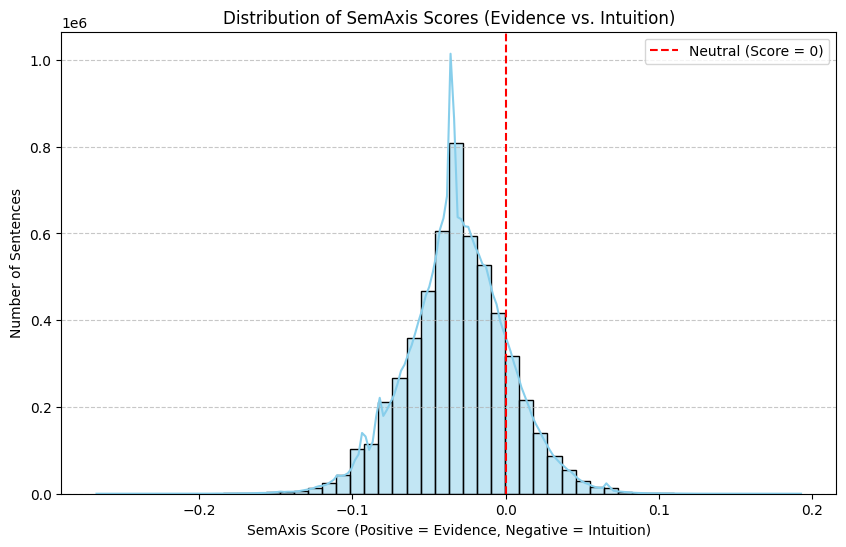

In [ ]:
# Filter out NaN scores for plotting
valid_scores = df_scored['sentence_score'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(valid_scores, bins=50, kde=True, color='skyblue')
plt.title('Distribution of SemAxis Scores (Evidence vs. Intuition)')
plt.xlabel('SemAxis Score (Positive = Evidence, Negative = Intuition)')
plt.ylabel('Number of Sentences')
plt.axvline(x=0, color='red', linestyle='--', label='Neutral (Score = 0)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

5. TF-IDF
- Input: `dialogue` and `tokens`:
- Explanation: Treating each sentence as its own 'document', get the TF-IDF score for each token.
- Output: {word: tf-idf score}

In [ ]:
def calculate_tfidf_scores(df_tokenized, save_path=None, min_df=5, max_df=0.95):

    #convert tokens to strings for TfidfVectorizer
    df_tokenized = df_tokenized.copy()
    df_tokenized['tokens_string'] = df_tokenized['tokens'].apply(lambda x: ' '.join(x))

    #initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        lowercase=False,  # Already lowercased in tokenization
        token_pattern=r'(?u)\S+',  # Match any non-whitespace as token
        min_df=min_df,
        max_df=max_df,
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True  # Use log scaling for term frequency
    )

    #fit and transform the corpus
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_tokenized['tokens_string'])

    #get feature names (words)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    #create dictionary to store TF-IDF scores
    word_tfidf_scores = defaultdict(list)

    #convert sparse matrix to COO format for efficient iteration
    tfidf_coo = tfidf_matrix.tocoo()

    for doc_idx, word_idx, tfidf_score in zip(tfidf_coo.row, tfidf_coo.col, tfidf_coo.data):
        word = feature_names[word_idx]
        word_tfidf_scores[word].append(tfidf_score)

    #calculate mean and max TF-IDF scores
    word_tfidf_mean = {word: sum(scores)/len(scores)
                       for word, scores in word_tfidf_scores.items()}
    word_tfidf_max = {word: max(scores)
                      for word, scores in word_tfidf_scores.items()}

    #save to files if path provided
    if save_path:
        # Save as CSV
        tfidf_df = pd.DataFrame({
            'word': list(word_tfidf_mean.keys()),
            'mean_tfidf': list(word_tfidf_mean.values()),
            'max_tfidf': [word_tfidf_max[w] for w in word_tfidf_mean.keys()]
        })
        tfidf_df = tfidf_df.sort_values('mean_tfidf', ascending=False)
        tfidf_df.to_csv(f'{save_path}_scores.csv', index=False)

        #save as pickle dictionaries
        with open(f'{save_path}_mean.pkl', 'wb') as f:
            pickle.dump(word_tfidf_mean, f)
        with open(f'{save_path}_max.pkl', 'wb') as f:
            pickle.dump(word_tfidf_max, f)

    return word_tfidf_mean, word_tfidf_max, tfidf_vectorizer

In [ ]:
# load the tokenized dataframe
df_tokenized = pd.read_csv(intermediate_path + 'df_tokenized.csv')
df_tokenized['tokens'] = df_tokenized['tokens'].apply(ast.literal_eval)

# run TF-IDF calculations
save_path = intermediate_path + 'word_tfidf'
word_tfidf_mean, word_tfidf_max, tfidf_vectorizer = calculate_tfidf_scores(
    df_tokenized,
    save_path=save_path,
    min_df=20,
    max_df=0.95
)

6. Score sentences
- Input: DF `dialogue`, word to SemAxis scores, word to TF-IDF scores
- Explanation: For each sentence, Convert the word-level scores to sentence-level scores. Average the scores of its words weighted by TF-IDF. Specifically, for each sentence, get sum(semaxis score * tfidf score) / sum(tf idf score)
- Output: New col `sentence_score` in the DF for each sentence.

In [ ]:
def score_sentences(df_tokenized, semaxis_scores, tfidf_scores, min_tokens=3):

    # Initialize lists to store results
    sentence_scores = []
    valid_token_counts = []
    total_token_counts = []

    # Score each sentence
    for tokens in df_tokenized['tokens']:
        # Convert to list if needed
        if isinstance(tokens, str):
            tokens = ast.literal_eval(tokens)

        total_token_counts.append(len(tokens))

        # Calculate weighted score
        weighted_sum = 0.0
        weight_sum = 0.0
        valid_tokens = 0

        for token in tokens:
            # Check if token exists in both vocabularies
            if token in semaxis_scores and token in tfidf_scores:
                semaxis_val = semaxis_scores[token]
                tfidf_val = tfidf_scores[token]

                weighted_sum += semaxis_val * tfidf_val
                weight_sum += tfidf_val
                valid_tokens += 1

        valid_token_counts.append(valid_tokens)

        if weight_sum > 0 and valid_tokens >= min_tokens:
            score = weighted_sum / weight_sum
            sentence_scores.append(score)
        else:
            sentence_scores.append(np.nan)

    # Add scores to dataframe
    df_scored = df_tokenized.copy()
    df_scored['sentence_score'] = sentence_scores
    df_scored['valid_tokens'] = valid_token_counts
    df_scored['total_tokens'] = total_token_counts

    # Filter out invalid sentences
    df_valid = df_scored[~df_scored['sentence_score'].isna()].copy()
    df_valid = df_valid[~df_valid['dialogue'].str.isupper()].copy()  # Remove all-caps
    df_valid = df_valid[df_valid['dialogue'].str.count(r'\.') <= 3].copy()  # Remove >3 periods
    df_valid = df_valid[~df_valid['dialogue'].str.contains(r'\[|\]', regex=True)].copy()  # Remove brackets

    return df_valid

In [ ]:
# Paths
TOKENIZED_DF_PATH = intermediate_path + 'df_tokenized.csv'
TFIDF_MEAN_PATH = intermediate_path + 'word_tfidf_mean.pkl'
SEMAXIS_SCORES_PATH = intermediate_path + 'semaxis_scores.pkl'
OUTPUT_PATH = intermediate_path + 'df_scored.csv'

# Load tokenized dataframe
df_tokenized = pd.read_csv(TOKENIZED_DF_PATH)
df_tokenized['tokens'] = df_tokenized['tokens'].apply(ast.literal_eval)

# Load TF-IDF scores
with open(TFIDF_MEAN_PATH, 'rb') as f:
    tfidf_scores = pickle.load(f)

# Load SemAxis scores
with open(SEMAXIS_SCORES_PATH, 'rb') as f:
    semaxis_scores = pickle.load(f)

# Score sentences
df_scored = score_sentences(
    df_tokenized,
    semaxis_scores,
    tfidf_scores,
    min_tokens=3,
    verbose=True
)

# Save results
df_scored.to_csv(OUTPUT_PATH, index=False)

### BERT Regression Fine-Tuning
7. Split DF into train/validation/test sets
- Input: DF `dialogue` and `sentence_score`
- Explanation: Min-Max normalize the sentence_score first so we are on a [0, 1] scale like the education percentages. Makes interpretation easier and cleaner. Group the scores into 5 bins by range of 0.2. Then prepare dataset for training by splitting dataset into train/validation/test sets (70/15/15) using stratified sampling using these bins. Validation set is needed to prevent overfitting. Testing set is used to see performance of the model on completely unseen data.
- Output: `df_train`, `df_val`, `df_test`


In [ ]:
df_sentence_label = pd.read_csv(intermediate_path + 'df_scored.csv')

In [ ]:
df_sentence_label.head()

,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score,valid_tokens,total_tokens,abs_score,sentence_label
0,California,115,35,"It seems like we were going back and forth, ta...",0.155950,"['it', 'seems', 'like', 'we', 'were', 'going',...",-0.092705,29,29,0.092705,0
1,Massachusetts,117,9,"Freedom House notes that, quote, ``While civil...",0.391167,"['freedom', 'house', 'notes', 'that', ',', 'qu...",-0.084175,39,39,0.084175,0
2,California,116,37,Attorney General Barr.,0.400547,"['attorney', 'general', 'barr', '.']",-0.048275,4,4,0.048275,0
3,California,113,53,So it is--despite what General Rice and Genera...,0.346292,"['so', 'it', 'is', ' ', 'despite', 'what', 'ge...",-0.058612,43,44,0.058612,0
4,Massachusetts,117,7,It is critical we enact legislation to bring s...,0.479024,"['it', 'is', 'critical', 'we', 'enact', 'legis...",-0.012802,20,20,0.012802,0


In [ ]:
# Normalize sentence_score to be between 0 and 1
# Using min-max normalization: (x - min) / (max - min)

df_sentence_label['sentence_score_normalized'] = (df_sentence_label['sentence_score'] - df_sentence_label['sentence_score'].min()) / (df_sentence_label['sentence_score'].max() - df_sentence_label['sentence_score'].min())

In [ ]:
df_sentence_label.head()

,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score,valid_tokens,total_tokens,abs_score,sentence_label,sentence_score_normalized
0,California,115,35,"It seems like we were going back and forth, ta...",0.155950,"['it', 'seems', 'like', 'we', 'were', 'going',...",-0.092705,29,29,0.092705,0,0.379105
1,Massachusetts,117,9,"Freedom House notes that, quote, ``While civil...",0.391167,"['freedom', 'house', 'notes', 'that', ',', 'qu...",-0.084175,39,39,0.084175,0,0.397665
2,California,116,37,Attorney General Barr.,0.400547,"['attorney', 'general', 'barr', '.']",-0.048275,4,4,0.048275,0,0.475780
3,California,113,53,So it is--despite what General Rice and Genera...,0.346292,"['so', 'it', 'is', ' ', 'despite', 'what', 'ge...",-0.058612,43,44,0.058612,0,0.453287
4,Massachusetts,117,7,It is critical we enact legislation to bring s...,0.479024,"['it', 'is', 'critical', 'we', 'enact', 'legis...",-0.012802,20,20,0.012802,0,0.552965


In [ ]:
# verifying normalization worked
print(f"Min: {df_sentence_label['sentence_score_normalized'].min()}")
print(f"Max: {df_sentence_label['sentence_score_normalized'].max()}")
print(f"\nOriginal score range: [{df_sentence_label['sentence_score'].min():.4f}, {df_sentence_label['sentence_score'].max():.4f}]")

Min: 0.0
Max: 1.0

Original score range: [-0.2669, 0.1926]


In [ ]:
# renaming the sentence score so it is clear that it came from semaxis
df_sentence_label.rename(columns={'sentence_score': 'sentence_score_semaxis'}, inplace=True)

In [ ]:
df_sentence_label.head()

,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score_semaxis,valid_tokens,total_tokens,abs_score,sentence_score_normalized
0,California,115,35,"It seems like we were going back and forth, ta...",0.155950,"['it', 'seems', 'like', 'we', 'were', 'going',...",-0.092705,29,29,0.092705,0.379105
1,Massachusetts,117,9,"Freedom House notes that, quote, ``While civil...",0.391167,"['freedom', 'house', 'notes', 'that', ',', 'qu...",-0.084175,39,39,0.084175,0.397665
2,California,116,37,Attorney General Barr.,0.400547,"['attorney', 'general', 'barr', '.']",-0.048275,4,4,0.048275,0.475780
3,California,113,53,So it is--despite what General Rice and Genera...,0.346292,"['so', 'it', 'is', ' ', 'despite', 'what', 'ge...",-0.058612,43,44,0.058612,0.453287
4,Massachusetts,117,7,It is critical we enact legislation to bring s...,0.479024,"['it', 'is', 'critical', 'we', 'enact', 'legis...",-0.012802,20,20,0.012802,0.552965


In [ ]:
# Bin the normalized scores for stratification
# 5 ranges: [0, 0.2), [0.2, 0.4), [0.4, 0.6), [0.6, 0.8), [0.8, 1.0]

bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['very_intuition', 'intuition', 'mixed', 'evidence', 'very_evidence']

df_sentence_label['score_bin'] = pd.cut(
    df_sentence_label['sentence_score_normalized'],
    bins=bins,
    labels=labels,
    right=False # Makes intervals [0, 0.2), [0.2, 0.4), etc.
)

# Manually handle the upper bound (1.0) to be inclusive
df_sentence_label.loc[
    df_sentence_label['sentence_score_normalized'] == 1.0,
    'score_bin'
] = 'very_evidence'

# Check the distribution
print("Score bin distribution:")
print(df_sentence_label['score_bin'].value_counts().sort_index())

Score bin distribution:
score_bin
very_intuition       1329
intuition          316469
mixed             4553866
evidence           547910
very_evidence         864
Name: count, dtype: int64


/tmp/ipython-input-1849551266.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_sample = df_train.groupby('score_bin', group_keys=False).apply(
/tmp/ipython-input-1849551266.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sample = df_train.groupby('score_bin', group_keys=False).apply(



Train size: 3794306 (70.0%)
Val size: 813066 (15.0%)
Test size: 813066 (15.0%)


In [ ]:
# Split: 70% train, 15% val, 15% test
df_train, df_val_test = train_test_split(
    df_sentence_label,
    test_size=0.3,
    stratify=df_sentence_label['score_bin'],
    random_state=42
)

df_val, df_test = train_test_split(
    df_val_test,
    test_size=0.5,
    stratify=df_val_test['score_bin'],
    random_state=42
)

# Verify split sizes
print(f"\nTrain size: {len(df_train)} ({len(df_train)/len(df_sentence_label):.1%})")
print(f"Val size: {len(df_val)} ({len(df_val)/len(df_sentence_label):.1%})")
print(f"Test size: {len(df_test)} ({len(df_test)/len(df_sentence_label):.1%})")

# Save the file names
df_train.to_csv(intermediate_path + 'df_train.csv')
df_val.to_csv(intermediate_path + 'df_val.csv')
df_test.to_csv(intermediate_path + 'df_test.csv')

8. Fine-tune BERT
- Input: `df_train`
- Explanation: Using the pre-trained BERT model, we fine-tune BERT so it understands that evidence-based sentences look like _this_ and intuition-based sentences look like _that_. We use BERT because it analyzes the context even more than what we did with SemAxis, which will create better predictions. Decide which BERT model would be most appropriate for our task. Also, tune hyperparameters.
- Output: The fine-tuned BERT model itself. Let's call this trained model.

In [ ]:
# BERT expects col to be named label
# For regression, the 'label' column should contain the continuous scores
df_train['label'] = df_train['sentence_score_normalized']
df_val['label'] = df_val['sentence_score_normalized']
df_test['label'] = df_test['sentence_score_normalized']

# Make sure label is float
df_train['label'] = df_train['label'].astype(float)
df_val['label'] = df_val['label'].astype(float)
df_test['label'] = df_test['label'].astype(float)

In [ ]:
df_train.head()

,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score_semaxis,valid_tokens,total_tokens,abs_score,sentence_score_normalized,score_bin,label
1052015,Ohio,117,13,And maybe we can even have a conversation with...,0.280410,"['and', 'maybe', 'we', 'can', 'even', 'have', ...",-0.016806,64,66,0.016806,0.544252,mixed,0.544252
2729254,Ohio,113,4,Did they say to do it or not do it?,0.163028,"['did', 'they', 'say', 'to', 'do', 'it', 'or',...",-0.084073,11,11,0.084073,0.397887,intuition,0.397887
4166165,Florida,116,22,Secretary Schenker.,0.402607,"['secretary', 'schenker', '.']",-0.030976,3,3,0.030976,0.513420,mixed,0.513420
40051,Utah,116,2,"Children, while they are adaptive and resilien...",0.333681,"['children', ',', 'while', 'they', 'are', 'ada...",-0.031059,20,20,0.031059,0.513240,mixed,0.513240
4767729,California,117,36,What kind of procedures do hospitals need in o...,0.438686,"['what', 'kind', 'of', 'procedures', 'do', 'ho...",-0.005868,19,19,0.005868,0.568053,mixed,0.568053


In [ ]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train[['dialogue', 'label']])
val_dataset = Dataset.from_pandas(df_val[['dialogue', 'label']])
test_dataset = Dataset.from_pandas(df_test[['dialogue', 'label']])

In [ ]:
# Tokenize using BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(dataset):
    return bert_tokenizer(
        dataset['dialogue'],
        padding='max_length', # if less than 128 tokens then add padding
        truncation=True, # if more than 128 tokens then truncate
        max_length=128 # cut off at 128 tokens
    )

# Apply tokenization to the Dataset objects
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3794306 [00:00<?, ? examples/s]

Map:   0%|          | 0/813066 [00:00<?, ? examples/s]

Map:   0%|          | 0/813066 [00:00<?, ? examples/s]

In [ ]:
# Load model for regression
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=1, # 1 for regression
    problem_type="regression"  # Explicitly set to regression
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    mae = mean_absolute_error(labels, predictions)
    return {'mae': mae}

In [ ]:
# set up training
training_args = TrainingArguments(
    output_dir=intermediate_path + 'BERT/results', # where to save everything during training
    num_train_epochs=3, # higher the epoch more chance of overfitting
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    learning_rate=2e-5,
    eval_strategy="epoch", # evaluate after every epoch
    save_strategy="epoch", # save after every epoch incase of crash during run
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model='mae', # mean squared error appropriate for our use case
    greater_is_better=False,
    logging_steps=500,
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train BERT
# Check if there are existing checkpoints before training
# epoch 1: training loss (0.000100), validation loss (0.000029), MAE (0.003092)
# epoch 2: training loss (0.000100), validation loss (0.000018), MAE (0.002613)
# epoch 3: training loss (0.000000), validation loss (0.000012), MAE (0.002002)

checkpoint_dir = intermediate_path + 'BERT/results'
checkpoints = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint')]

if checkpoints: # handles case when we need to rerun after a crash. we crashed during epoch 2 so started again from epoch 3 (which is why only epoch 3 is displayed)
    latest_checkpoint = max(checkpoints, key=os.path.getctime)
    print(f"Resuming from {latest_checkpoint}")
    trainer.train(resume_from_checkpoint=latest_checkpoint)
else:
    print("Starting fresh training")
    trainer.train()

Resuming from /content/drive/MyDrive/ANLP Project/Data/Intermediate/BERT/results2/checkpoint-118574


Epoch,Training Loss,Validation Loss,Mae
3,0.000000,0.000012,0.002002


In [ ]:
# this is evaluating on validation set
# 'eval_loss': 1.1999673006357625e-05, 'eval_mae': 0.0020016764756292105
results = trainer.evaluate()
print(f'Results: {results}')

Results: {'eval_loss': 1.1999673006357625e-05, 'eval_mae': 0.0020016764756292105, 'eval_runtime': 359.8192, 'eval_samples_per_second': 2259.651, 'eval_steps_per_second': 17.656, 'epoch': 3.0}


In [ ]:
# save model
trainer.save_model(intermediate_path + 'BERT/trained_model/')
bert_tokenizer.save_pretrained(intermediate_path + 'BERT/trained_model/')
print('Model saved.')

Model saved.


In [ ]:
# generate predictions on test set
test_predictions = trainer.predict(test_dataset)
print('Prediction on test dataset complete!')

Prediction on test dataset complete!


In [ ]:
test_predictions.metrics # print MAE

{'test_loss': 1.2030482139380183e-05,
 'test_mae': 0.001998116262257099,
 'test_runtime': 366.4469,
 'test_samples_per_second': 2218.783,
 'test_steps_per_second': 17.337}

9. Get predictions and evaluations for the entire dataset
- Input: trained model, entire dataset
- Explanation: Now, use the trained model to predict BERT scores for the entire dataset. We use MAE as our metric of evaluation as it is more interpretable than MSE, is less sensitive to outliers, and works well on [0, 1] scales. Min-max normalize the BERT scores; since this is a regression, the output could be slightly below 0 or slightly above 1.
- Output: validation metric (MAE score)

In [ ]:
df_sentence_label['label'] = df_sentence_label['sentence_score_normalized']
df_sentence_label['label'] = df_sentence_label['label'].astype(float)

In [ ]:
# generate predictions for entire dataset
entire_dataset = Dataset.from_pandas(df_sentence_label[['dialogue', 'label']])
entire_dataset = entire_dataset.map(tokenize_function, batched=True)
predictions = trainer.predict(entire_dataset)
print('Prediction on entire dataset complete!')

Map:   0%|          | 0/5420438 [00:00<?, ? examples/s]

Prediction on entire dataset complete!


In [ ]:
predictions.metrics # print MAE using entire dataset

{'test_loss': 1.006736511044437e-05,
 'test_mae': 0.001942352275364101,
 'test_runtime': 2420.3917,
 'test_samples_per_second': 2239.488,
 'test_steps_per_second': 17.496}

In [ ]:
# add predictions to the dataframe
pred_values = predictions.predictions.squeeze()
df_sentence_label['bert_score'] = pred_values

df_sentence_label.head(1)

,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score_semaxis,valid_tokens,total_tokens,abs_score,sentence_score_normalized,score_bin,label,bert_score
0,California,115,35,"It seems like we were going back and forth, talking about theories, and maybe we ought to try this, maybe we ought to try that.",0.15595,"['it', 'seems', 'like', 'we', 'were', 'going', 'back', 'and', 'forth', ',', 'talking', 'about', 'theories', ',', 'and', 'maybe', 'we', 'ought', 'to', 'try', 'this', ',', 'maybe', 'we', 'ought', 'to', 'try', 'that', '.']",-0.092705,29,29,0.092705,0.379105,intuition,0.379105,0.37793


In [ ]:
# min-max normalize the BERT scores to [0, 1]: (x - min) / (max - min)
df_sentence_label['bert_score'] = (df_sentence_label['bert_score'] - df_sentence_label['bert_score'].min()) / (df_sentence_label['bert_score'].max() - df_sentence_label['bert_score'].min())

In [ ]:
# save the results
df_sentence_label.rename(columns={'sentence_score_normalized': 'semaxis_score_normalized'}, inplace=True)
df_sentence_label.to_csv(intermediate_path + 'df_predictions.csv')

In [ ]:
print(df_sentence_label['bert_score'].max(),
      df_sentence_label['bert_score'].min(),
      df_sentence_label['bert_score'].mean())

1.0 0.0 0.5113872461234388


In [ ]:
df_sentence_label.head(1)

,Unnamed: 0,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score_semaxis,valid_tokens,total_tokens,abs_score,semaxis_score_normalized,score_bin,label,bert_score
0,0,California,115,35,"It seems like we were going back and forth, talking about theories, and maybe we ought to try this, maybe we ought to try that.",0.15595,"['it', 'seems', 'like', 'we', 'were', 'going', 'back', 'and', 'forth', ',', 'talking', 'about', 'theories', ',', 'and', 'maybe', 'we', 'ought', 'to', 'try', 'this', ',', 'maybe', 'we', 'ought', 'to', 'try', 'that', '.']",-0.092705,29,29,0.092705,0.379105,intuition,0.379105,0.379762


10. Human Labeling & Validation

- Input: `sentence_score_normalized` (semaxis+tfidf weighted scores), `bert_score`
- Details: Now we have the scores [0, 1] (closer to 0 = intuition, closer to 1 = evidence) from both Semaxis and BERT. How do we know which model is better? We will use human labeling (0-5) as 'ground truth' to compare (1) human label vs semaxis scores, and (2) human label vs BERT scores. The method to 'compare' will be using (1) pearson correlation and (2) mean squared error and mean absolute error. Whichever has higher pearson correlation value and/or less mean squared/absolute error is the better model. Get 200 random sentences (40 per bin since there is high class imbalance) from the test data (unseen data) to human label on a 0-5 scale. We have 3 annotators. After human labeling is complete, calculate Krippendorff's Alpha to make sure there is high interannotator agreement.
- Output: (1) correlation between human label and semaxis scores, (2) correlation between human label and bert scores, (3) MSE between human label and semaxis scores, (4) MSE between human label and bert scores, (5) MAE between human label and semaxis scores, (6) MAE between human label and bert scores.

In [ ]:
df_test = pd.read_csv(intermediate_path + 'df_test.csv')
print(df_test.shape)
df_test.head(1)

(813066, 13)


,Unnamed: 0,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score_semaxis,valid_tokens,total_tokens,abs_score,sentence_score_normalized,score_bin
0,1281039,Pennsylvania,115,16,Can you explain why you believe that a regulated air traffic service provider would be outside of democratic oversight?,0.264733,"['can', 'you', 'explain', 'why', 'you', 'believe', 'that', 'a', 'regulated', 'air', 'traffic', 'service', 'provider', 'would', 'be', 'outside', 'of', 'democratic', 'oversight', '?']",-0.021128,20,20,0.021128,0.534848,mixed


Randomly pick 40 sentences from each of the 5 bins -- 200 sentences total.

In [ ]:
total_n = 200
bin_n = int(total_n / 5)

df_human_label = df_test.groupby('score_bin', group_keys=False).apply(
    lambda x: x.sample(n=bin_n, random_state=42)
)
df_human_label.groupby('score_bin').size()

/tmp/ipython-input-3603141965.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_human_label = df_test.groupby('score_bin', group_keys=False).apply(


,0
score_bin,
evidence,40
intuition,40
mixed,40
very_evidence,40
very_intuition,40


In [ ]:
df_human_label.head(1)

,Unnamed: 0,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score_semaxis,valid_tokens,total_tokens,abs_score,sentence_score_normalized,score_bin
358646,934814,Colorado,114,6,"Thank you, Ranking Member Kuster.",0.412035,"['thank', 'you', ',', 'ranking', 'member', 'kuster', '.']",0.009916,7,7,0.009916,0.602397,evidence


In [ ]:
df_human_label = df_human_label.sample(frac=1, replace=False, random_state=42)[['state', 'congress', 'district', 'dialogue', 'sentence_score_normalized']] # randomly shuffle the 200 sentences
df_human_label.head(1)
print(df_human_label.shape)

(200, 5)


In [ ]:
# At this point, we only have the semaxis scores in the df.
# Join the test data with df_predictions that contains the BERT scores as well.
df_predictions = pd.read_csv(intermediate_path + 'df_predictions.csv')
df_pred_unique = df_predictions[['state', 'congress', 'district', 'dialogue', 'bert_score']].drop_duplicates()

In [ ]:
df_human_label = pd.merge(df_human_label, df_pred_unique,
                  how='left',
                  left_on=['state', 'congress', 'district', 'dialogue'],
                  right_on=['state', 'congress', 'district', 'dialogue'])
df_human_label.shape

(200, 6)

In [ ]:
df_human_label.head(1)

,state,congress,district,dialogue,sentence_score_normalized,bert_score
0,California,113,49,"The concentration of Federal buildings, new Federal buildings in the District will only exacerbate that concentration.",0.58978,0.591142


In [ ]:
df_human_label.to_csv(intermediate_path + 'df_human_label.csv')

Once human labeling is complete, make sure there is high inter annotator agreement using Krippendorff's alpha.

- alpha = 1 --> perfect agreement
- alpha >= 0.8 --> good reliability
- alpha < 0.8 --> too low for our study
- alpha = 0 --> agreement by chance
- alpha < 0 --> systematic disagreement (worse than random)

In [ ]:
# load in human labels
# should be 200 rows, containing semaxis scores, bert scores, and human label means

# Your Google Sheets URL
url = 'https://docs.google.com/spreadsheets/d/1__uBe9zIpq712yKP-Fjv7TrypN5kqS3PQAno4rv8G9U/edit?gid=407572902#gid=407572902'

# Convert to export format
# Replace YOUR_SHEET_ID with the actual ID from your URL
sheet_id = '1__uBe9zIpq712yKP-Fjv7TrypN5kqS3PQAno4rv8G9U'
sheet_name = 'Combined'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

df_labeled = pd.read_csv(url)
print(df_labeled.shape)
df_labeled.head(3)

(200, 11)


,state,congress,district,dialogue,sentence_score_normalized,bert_score,Avery,Patrick,Sanjali,mean_human_label,mean_human_prob
0,California,113,49,"The concentration of Federal buildings, new Federal buildings in the District will only exacerbate that concentration.",0.589780,0.591142,4,4,4,4.0,0.8
1,Indiana,116,3,Admiral Gilday.,0.666153,0.667353,3,3,3,3.0,0.6
2,Pennsylvania,117,8,"Administrator Nelson, first of all, thank you for mentioning the internship program at NASA.",0.643006,0.642908,3,3,3,3.0,0.6


In [ ]:
reliability_matrix = [
    df_labeled['Avery'].values,
    df_labeled['Patrick'].values,
    df_labeled['Sanjali'].values
]

alpha = krippendorff.alpha(reliability_data=reliability_matrix, level_of_measurement='ordinal')
print(f"Krippendorff's alpha: {alpha}")
# the krippendorff's alpha is 0.8018160647883134, suggesting high inter annotator agreement

Krippendorff's alpha: 0.8018160647883134


After we make sure there is high inter annotator agreement, get the correlation, MSE, and MAE.

In [ ]:
# Calculate correlation with human ratings
# pearson for continuous values [0, 1]
corr_semaxis, p1 = pearsonr(df_labeled['mean_human_prob'], df_labeled['sentence_score_normalized'])
corr_bert, p2 = pearsonr(df_labeled['mean_human_prob'], df_labeled['bert_score'])

# Calculate errors
mse_semaxis = mean_squared_error(df_labeled['mean_human_prob'], df_labeled['sentence_score_normalized'])
mse_bert = mean_squared_error(df_labeled['mean_human_prob'], df_labeled['bert_score'])

mae_semaxis = mean_absolute_error(df_labeled['mean_human_prob'], df_labeled['sentence_score_normalized'])
mae_bert = mean_absolute_error(df_labeled['mean_human_prob'], df_labeled['bert_score'])

print(f"SemAxis correlation: {corr_semaxis:.3f}, BERT correlation: {corr_bert:.3f}")
print(f"SemAxis MSE: {mse_semaxis:.4f}, BERT MSE: {mse_bert:.4f}")
print(f"SemAxis MAE: {mae_semaxis:.4f}, BERT MAE: {mae_bert:.4f}")

SemAxis correlation: 0.866, BERT correlation: 0.864
SemAxis MSE: 0.0217, BERT MSE: 0.0219
SemAxis MAE: 0.1105, BERT MAE: 0.1108


The Semaxis correlation is slightly higher than BERT, and semaxis MSE and MAE are slightly lower than BERT, suggesting it may be a better model. BUT, is this difference statistically significant or is it by random chance? We can use the Steiger's z-test to compare.

In [ ]:
corr_semaxis_bert, p3 = pearsonr(df_labeled['sentence_score_normalized'], df_labeled['bert_score'])
n = len(df_labeled) # sample size
print(corr_semaxis_bert, n)

# Steiger's Z-test for dependent correlations
def steiger_z_test(r12, r13, r23, n):
    """
    r12: correlation between variable 1 (human) and 2 (semaxis)
    r13: correlation between variable 1 (human) and 3 (bert)
    r23: correlation between variable 2 (semaxis) and 3 (bert)
    n: sample size
    """
    # Average correlation
    r_avg = (r12 + r13) / 2

    # Determinant
    det = (1 - r12**2 - r13**2 - r23**2) + (2 * r12 * r13 * r23)

    # Z statistic
    z = (r12 - r13) * np.sqrt((n - 3) / (2 * (1 - r23**2) * det))

    # P-value (two-tailed)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))

    return z, p_value

# Run test
z_stat, p_value = steiger_z_test(corr_semaxis, corr_bert, corr_semaxis_bert, n)

print(f"Steiger's Z = {z_stat:.4f}")
print(f"P-value = {p_value:.4f}")
# even though the p-value < 0.05 suggesting there is a difference in correlation with human labels between the models,
# the effect size (corr semaxis - corr bert = 0.002) is so small that the difference is negligible.
# The Right Way to Report This
# Although Steiger's Z-test detected a statistically significant difference between correlations (Z = 68.84, p < 0.001),
# the effect size is negligible (Δr = 0.002). Both SemAxis (MAE = 0.1105) and BERT (MAE = 0.1108) perform nearly identically
# in predicting human labels, with an extremely high correlation between their predictions (r = 0.9996).
# This suggests both methods capture essentially the same underlying construct.

0.9996218357500251 200
Steiger's Z = 68.8443
P-value = 0.0000


The MAE for both seem to be very low at 0.11, but is this actually low? Compare against the majority class (mean) baseline. Calculate baseline errors: what if we predicted mean_human_label for every sentence?

In [ ]:
mean_human_label = df_labeled['mean_human_prob'].mean()

print(f'Mean human label (naive prediction): {mean_human_label:.4f}\n')

# Calculate baseline errors: what if we predicted mean_human_label for EVERY sentence?
df_labeled['baseline_abs_diff'] = abs(df_labeled['mean_human_prob'] - mean_human_label)

# This is the same baseline for both models (comparing against human labels)
baseline_mae = df_labeled['baseline_abs_diff'].mean()

print(f'Baseline MAE (predicting mean for all): {baseline_mae:.4f}')
print(f'SemAxis MAE: {mae_semaxis:.4f}')
print(f'BERT MAE: {mae_bert:.4f}\n')

# Calculate model errors
semaxis_errors = abs(df_labeled['mean_human_prob'] - df_labeled['sentence_score_normalized'])
bert_errors = abs(df_labeled['mean_human_prob'] - df_labeled['bert_score'])

# Baseline errors (same for both models)
baseline_errors = df_labeled['baseline_abs_diff']

# Statistical tests comparing each model to the shared baseline
t_stat_sem, p_val_sem = ttest_rel(baseline_errors, semaxis_errors)
t_stat_bert, p_val_bert = ttest_rel(baseline_errors, bert_errors)

# Paired Cohen's d
def cohens_d_paired(group1, group2):
    """Cohen's d for paired samples"""
    diff = group1 - group2
    return diff.mean() / diff.std()

d_semaxis = cohens_d_paired(baseline_errors, semaxis_errors)
d_bert = cohens_d_paired(baseline_errors, bert_errors)

# Print comprehensive report
print("="*70)
print("MODEL VALIDATION: COMPARISON TO BASELINE")
print("="*70)

print("\nBASELINE (Predicting Mean Human Label):")
print(f"  Baseline MAE:   {baseline_mae:.4f}")

print("\nSEMAXIS MODEL:")
print(f"  Model MAE:      {semaxis_errors.mean():.4f}")
print(f"  Baseline MAE:   {baseline_mae:.4f}")
print(f"  Improvement:    {(1 - semaxis_errors.mean()/baseline_mae)*100:.1f}%")
print(f"  t-statistic:    {t_stat_sem:.3f}")
print(f"  p-value:        {p_val_sem:.2e}")
print(f"  Cohen's d:      {d_semaxis:.3f} ({'Large' if abs(d_semaxis) > 0.8 else 'Medium' if abs(d_semaxis) > 0.5 else 'Small'})")
print(f"  Conclusion:     {'✓ Significantly better than baseline' if p_val_sem < 0.001 else '? Marginal'}")

print("\nBERT MODEL:")
print(f"  Model MAE:      {bert_errors.mean():.4f}")
print(f"  Baseline MAE:   {baseline_mae:.4f}")
print(f"  Improvement:    {(1 - bert_errors.mean()/baseline_mae)*100:.1f}%")
print(f"  t-statistic:    {t_stat_bert:.3f}")
print(f"  p-value:        {p_val_bert:.2e}")
print(f"  Cohen's d:      {d_bert:.3f} ({'Large' if abs(d_bert) > 0.8 else 'Medium' if abs(d_bert) > 0.5 else 'Small'})")
print(f"  Conclusion:     {'✓ Significantly better than baseline' if p_val_bert < 0.001 else '? Marginal'}")

print("="*70)

# Additional baselines for context

print("ADDITIONAL BASELINES FOR CONTEXT:")

# Random baseline
np.random.seed(42)
random_predictions = np.random.rand(len(df_labeled))
random_mae = abs(df_labeled['mean_human_prob'] - random_predictions).mean()
print(f"  Random prediction MAE: {random_mae:.4f}")

# Median baseline (alternative to mean)
median_human_label = df_labeled['mean_human_prob'].median()
median_baseline_mae = abs(df_labeled['mean_human_prob'] - median_human_label).mean()
print(f"  Median prediction MAE: {median_baseline_mae:.4f}")

Mean human label (naive prediction): 0.5127

Baseline MAE (predicting mean for all): 0.2557
SemAxis MAE: 0.1105
BERT MAE: 0.1108

MODEL VALIDATION: COMPARISON TO BASELINE

BASELINE (Predicting Mean Human Label):
  Baseline MAE:   0.2557

SEMAXIS MODEL:
  Model MAE:      0.1105
  Baseline MAE:   0.2557
  Improvement:    56.8%
  t-statistic:    13.901
  p-value:        3.80e-31
  Cohen's d:      0.983 (Large)
  Conclusion:     ✓ Significantly better than baseline

BERT MODEL:
  Model MAE:      0.1108
  Baseline MAE:   0.2557
  Improvement:    56.7%
  t-statistic:    13.657
  p-value:        2.15e-30
  Cohen's d:      0.966 (Large)
  Conclusion:     ✓ Significantly better than baseline

ADDITIONAL BASELINES FOR CONTEXT:
  Random prediction MAE: 0.3454
  Median prediction MAE: 0.2553


In [ ]:
# confidence intervals

# SemAxis vs Baseline
print("="*70)
print("SEMAXIS vs BASELINE (with Confidence Intervals)")
print("="*70)
result_sem = pg.ttest(baseline_errors, semaxis_errors, paired=True)
print(result_sem)

# BERT vs Baseline
print("\n" + "="*70)
print("BERT vs BASELINE (with Confidence Intervals)")
print("="*70)
result_bert = pg.ttest(baseline_errors, bert_errors, paired=True)
print(result_bert)

# Extract key values for reporting
print("\n" + "="*70)
print("SUMMARY WITH CONFIDENCE INTERVALS")
print("="*70)

# SemAxis
ci_sem = result_sem['CI95%'].values[0]
mean_diff_sem = (baseline_errors - semaxis_errors).mean()  # Calculate manually
# OR use this if pingouin has it in a column (check result_sem.columns)

print("\nSEMAXIS:")
print(f"  Mean difference: {mean_diff_sem:.4f}")  # FIXED
print(f"  95% CI: [{ci_sem[0]:.4f}, {ci_sem[1]:.4f}]")
print(f"  Cohen's d: {result_sem['cohen-d'].values[0]:.3f}")
print(f"  t({result_sem['dof'].values[0]:.0f}) = {result_sem['T'].values[0]:.3f}, p = {result_sem['p-val'].values[0]:.2e}")

# BERT
ci_bert = result_bert['CI95%'].values[0]
mean_diff_bert = (baseline_errors - bert_errors).mean()  # Calculate manually

print("\nBERT:")
print(f"  Mean difference: {mean_diff_bert:.4f}")  # FIXED
print(f"  95% CI: [{ci_bert[0]:.4f}, {ci_bert[1]:.4f}]")
print(f"  Cohen's d: {result_bert['cohen-d'].values[0]:.3f}")
print(f"  t({result_bert['dof'].values[0]:.0f}) = {result_bert['T'].values[0]:.3f}, p = {result_bert['p-val'].values[0]:.2e}")

print("="*70)

SEMAXIS vs BASELINE (with Confidence Intervals)
                T  dof alternative         p-val         CI95%   cohen-d  \
T-test  13.901373  199   two-sided  3.802450e-31  [0.12, 0.17]  1.205472   

             BF10 power  
T-test  8.097e+27   NaN  

BERT vs BASELINE (with Confidence Intervals)
                T  dof alternative         p-val         CI95%   cohen-d  \
T-test  13.657243  199   two-sided  2.145523e-30  [0.12, 0.17]  1.201117   

             BF10 power  
T-test  1.469e+27   NaN  

SUMMARY WITH CONFIDENCE INTERVALS

SEMAXIS:
  Mean difference: 0.1452
  95% CI: [0.1200, 0.1700]
  Cohen's d: 1.205
  t(199) = 13.901, p = 3.80e-31

BERT:
  Mean difference: 0.1450
  95% CI: [0.1200, 0.1700]
  Cohen's d: 1.201
  t(199) = 13.657, p = 2.15e-30


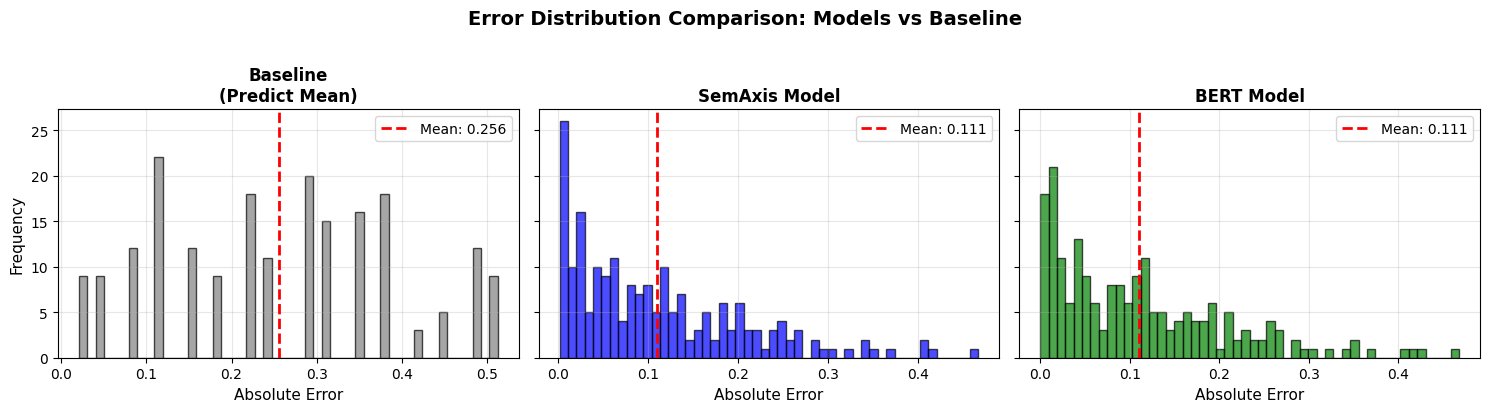

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Baseline
axes[0].hist(baseline_errors, bins=50, color='gray', alpha=0.7, edgecolor='black')
axes[0].axvline(baseline_errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {baseline_errors.mean():.3f}')
axes[0].set_title('Baseline\n(Predict Mean)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Absolute Error', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# SemAxis
axes[1].hist(semaxis_errors, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(semaxis_errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {semaxis_errors.mean():.3f}')
axes[1].set_title('SemAxis Model', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Absolute Error', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

# BERT
axes[2].hist(bert_errors, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[2].axvline(bert_errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {bert_errors.mean():.3f}')
axes[2].set_title('BERT Model', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Absolute Error', fontsize=11)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('Error Distribution Comparison: Models vs Baseline', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Aggregate and Prepare data for Regression Analysis
11. Aggregate
- Input: DF
- Explanation: By this point we should have `congress`, `state`, `district`, `bachelors_or_higher_percentage`, `bert_prob`. Aggregate by congress, state, district to find the mean for education % and bert score. The education % should already be unique to the specific rep in that congress in that state in that district. There are just multiple rows for them in the input DF because of the sentence expansion (many sentences for one person).
- Output: New DF with PK cols `congress`, `state`, `district`, and non-PK cols `bachelors_or_higher_percentage`, `semaxis_score_mean`, `bert_score_mean`

Human Labels vs Semaxis+TFIDF and Human Labels vs BERT

In [ ]:
df_pred = pd.read_csv(intermediate_path + 'df_predictions.csv')
df_pred.shape

(5420438, 16)

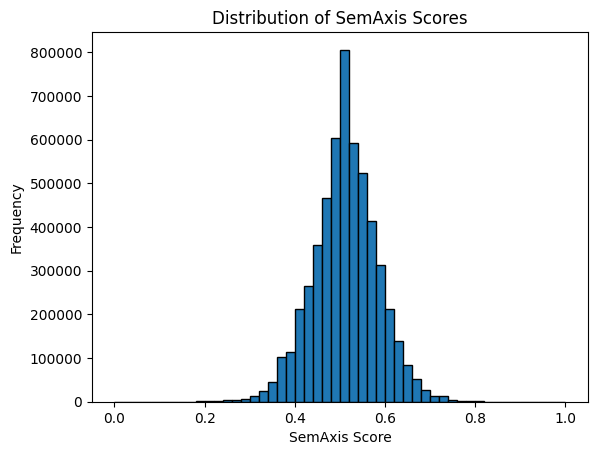

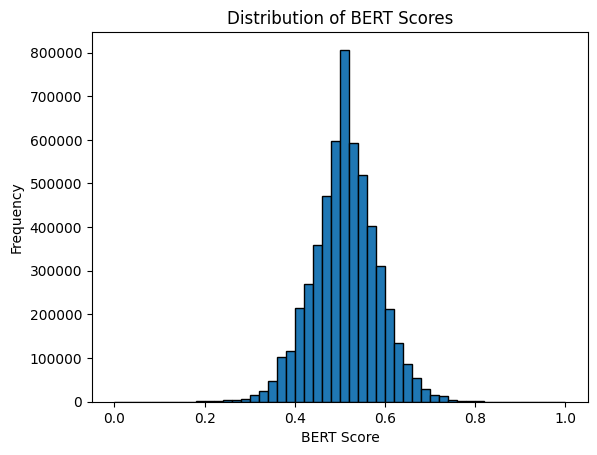

In [ ]:
# Histogram Semaxis
plt.hist(df_pred['semaxis_score_normalized'], bins=50, edgecolor='black')
plt.xlabel('SemAxis Score')
plt.ylabel('Frequency')
plt.title('Distribution of SemAxis Scores')
plt.show()

# Histogram BERT
plt.hist(df_pred['bert_score'], bins=50, edgecolor='black')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')
plt.title('Distribution of BERT Scores')
plt.show()

In [ ]:
# Aggregate entire dataset
aggregated_df = df_pred.groupby(['congress', 'state', 'district'], as_index=False).agg({
    'bachelors_or_higher_percentage': 'first',
    'semaxis_score_normalized': 'mean',
    'bert_score': 'mean'
}).rename(columns={'semaxis_score_normalized': 'semaxis_score_mean', 'bert_score': 'bert_score_mean'})

In [ ]:
aggregated_df.head()

,congress,state,district,bachelors_or_higher_percentage,semaxis_score_mean,bert_score_mean
0,112,Alabama,1,0.212369,0.509359,0.508887
1,112,Alabama,2,0.208726,0.508379,0.507929
2,112,Alabama,3,0.189533,0.524342,0.523986
3,112,Alabama,4,0.147444,0.553042,0.552782
4,112,Alabama,5,0.284376,0.542423,0.542116


In [ ]:
# save aggregated df
aggregated_df.to_csv(intermediate_path + 'df_aggregated.csv', index=False)
aggregated_df.shape

(2764, 6)

# Evidence/Intuition vs District Education Analysis
### Correlation Analysis
12. Understand our data
- Input: DF with predictions
- Explanation: Before we decide on our correlation methodologies, we need to understand our data. Plot out two plots, (x = `semaxis_score_mean`, y = `bachelors_or_higher_percentage`) and (x = `bert_score_mean`, y = `bachelors_or_higher_percentage`). Then, get the pearson correlation value.
- Output: Decision on our correlation analysis and evaluation methods.

In [ ]:
aggregated_df = pd.read_csv(intermediate_path + 'df_aggregated.csv')

In [ ]:
# need to merge bc didnt have party initially. added it in later in the project. if you rerun this entire script and have updated dfs, no need to run this.
df_with_names = pd.read_csv(intermediate_path + 'df_with_names.csv')
df_with_names = df_with_names[['state', 'district', 'congress', 'party']].drop_duplicates()
aggregated_df = aggregated_df.merge(df_with_names, how='left', on=['state', 'district', 'congress'])

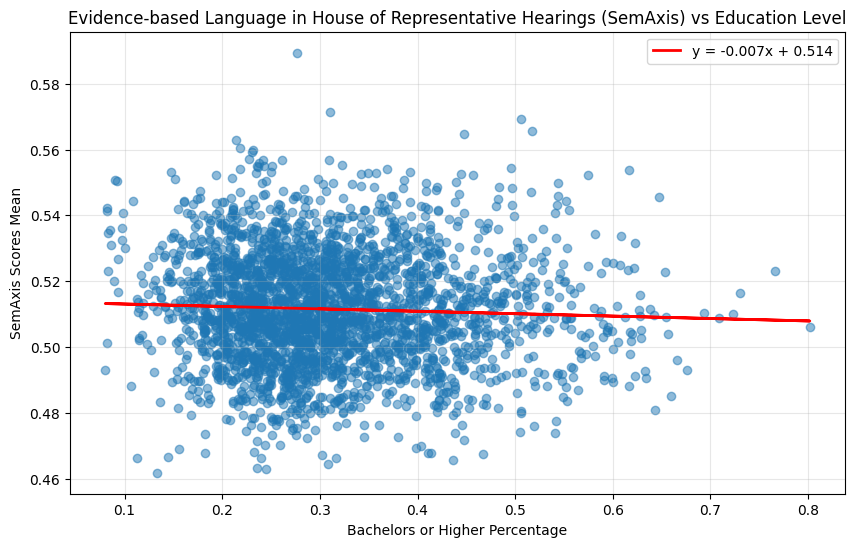

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(aggregated_df['bachelors_or_higher_percentage'],
            aggregated_df['semaxis_score_mean'],
            alpha=0.5)

z = np.polyfit(aggregated_df['bachelors_or_higher_percentage'], aggregated_df['semaxis_score_mean'], 1) # 1 = linear
p = np.poly1d(z)
plt.plot(aggregated_df['bachelors_or_higher_percentage'],
         p(aggregated_df['bachelors_or_higher_percentage']),
         "r-",
         linewidth=2,
         label=f'y = {z[0]:.3f}x + {z[1]:.3f}'
         ) # red line

plt.xlabel('Bachelors or Higher Percentage')
plt.ylabel('SemAxis Scores Mean')
plt.title('Evidence-based Language in House of Representative Hearings (SemAxis) vs Education Level')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show()

In [ ]:
# pearson correlation

corr, p_value = pearsonr(aggregated_df['bachelors_or_higher_percentage'], aggregated_df['semaxis_score_mean'])
coef_of_determination = corr ** 2

# corr = -0.04553126153373106 < 0.1 (negligible),
# coef of determination = 0.0020730957768530177 < 0.01 (trivial) -- the variable explains about 0.216% of the variance in the outcome,
# pvalue = 0.016669919587097896 < 0.05 (statistically significant)
print(corr, coef_of_determination, p_value)
# Despite statistical significance (pvalue < 0.05) due to large sample size (n > 2700),
# the correlation is negligible (r = -0.046, R² = 0.002),
# indicating district education has no meaningful predictive
# relationship with evidence-based language.

-0.04553126153373106 0.0020730957768530177 0.016669919587097896


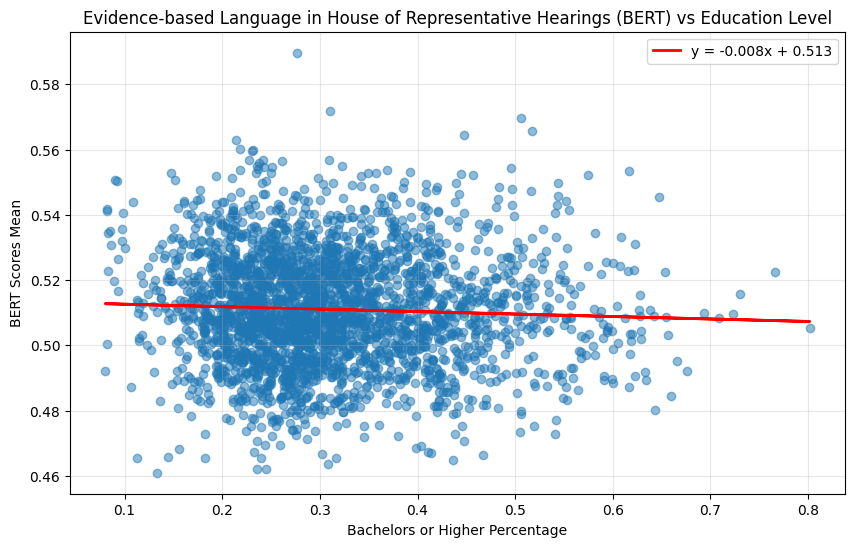

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(aggregated_df['bachelors_or_higher_percentage'],
            aggregated_df['bert_score_mean'],
            alpha=0.5
            )

z = np.polyfit(aggregated_df['bachelors_or_higher_percentage'], aggregated_df['bert_score_mean'], 1)  # 1 = linear
p = np.poly1d(z)
plt.plot(aggregated_df['bachelors_or_higher_percentage'],
         p(aggregated_df['bachelors_or_higher_percentage']),
         "r-",
         linewidth=2,
         label=f'y = {z[0]:.3f}x + {z[1]:.3f}'
        )  # red line

plt.xlabel('Bachelors or Higher Percentage')
plt.ylabel('BERT Scores Mean')
plt.title('Evidence-based Language in House of Representative Hearings (BERT) vs Education Level')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show()

In [ ]:
# pearson correlation

corr, p_value = pearsonr(aggregated_df['bachelors_or_higher_percentage'], aggregated_df['bert_score_mean'])
coef_of_determination = corr ** 2

# corr = -0.04651811324618072 < 0.1 (negligible),
# coef of determination = 0.0021639348599844944 < 0.01 (trivial) -- the variable explains about 0.216% of the variance in the outcome,
# pvalue = 0.014451118713120317 < 0.05 (statistically significant)
print(corr, coef_of_determination, p_value)
# Despite statistical significance (pvalue < 0.05) due to large sample size (n > 2700),
# the correlation is negligible (r = -0.047, R² = 0.002),
# indicating district education has no meaningful predictive
# relationship with evidence-based language.

-0.04651811324618067 0.0021639348599844896 0.014451118713120317


13. Mixed effects regression
- Input: DF with predictions
- Explanation: Since the datapoints in the above scatterplot are not independent from each other, do a mixed effects regression to take that into account and find both fixed and random effects. Group by `party` and `rep_id` (individuals).
- Output: observation and analysis on the relationship between rhetoric scores and education levels grouped by different attributes.

In [ ]:
df_pred = pd.read_csv(intermediate_path + 'df_predictions.csv')

In [ ]:
# we initially didnt have first and last names so i later reran the step 1 code to include it. merge df_with_names with df_predictions so we can also have the first and last names with the predictions
df_with_names = pd.read_csv(intermediate_path + 'df_with_names.csv')
df_with_names = df_with_names[['state', 'congress', 'district', 'party', 'first_name', 'last_name']].drop_duplicates()

In [ ]:
df = df_pred.merge(df_with_names, how='left', on=['state', 'district', 'congress'])
len(df[['state', 'district', 'congress']].drop_duplicates())
df.head(1)

,Unnamed: 0.1,Unnamed: 0,state,congress,district,dialogue,bachelors_or_higher_percentage,tokens,sentence_score_semaxis,valid_tokens,total_tokens,abs_score,semaxis_score_normalized,score_bin,label,bert_score,party,first_name,last_name
0,0,0,California,115,35,"It seems like we were going back and forth, talking about theories, and maybe we ought to try this, maybe we ought to try that.",0.15595,"['it', 'seems', 'like', 'we', 'were', 'going', 'back', 'and', 'forth', ',', 'talking', 'about', 'theories', ',', 'and', 'maybe', 'we', 'ought', 'to', 'try', 'this', ',', 'maybe', 'we', 'ought', 'to', 'try', 'that', '.']",-0.092705,29,29,0.092705,0.379105,intuition,0.379105,0.379762,Democrat,NORMA,TORRES


In [ ]:
# Create unique identifier for individual house of reps
df['rep_id'] = df['first_name'] + '_' + df['last_name']

In [ ]:
def mixed_effects_model(df, groupid='', model_type=''):
  print(f"Number of unique {groupid} combinations: {df[groupid].nunique()}")

  score_col = 'semaxis_score_normalized' if model_type == 'SemAxis' else 'bert_score'

  # FIT MIXED EFFECTS REGRESSION MODEL
  model = smf.mixedlm(
      f"{score_col} ~ bachelors_or_higher_percentage",
      data=df,
      groups=df[groupid],
      re_formula="~bachelors_or_higher_percentage"  # Allow slopes to vary
  ).fit()

  print("\n" + "="*60)
  print(f"MIXED EFFECTS MODEL RESULTS FOR {groupid}")
  print("="*60)
  print(model.summary())

  # KEY STATISTICS
  beta_education = model.params['bachelors_or_higher_percentage']
  se_education = model.bse['bachelors_or_higher_percentage']
  p_education = model.pvalues['bachelors_or_higher_percentage']
  ci_lower, ci_upper = model.conf_int().loc['bachelors_or_higher_percentage']

  # random effects variance
  group_var = model.cov_re.values[0][0]  # between-group variance
  residual_var = model.scale  # within-group variance
  icc = group_var / (group_var + residual_var)

  print("\n" + "="*60)
  print("KEY STATISTICS")
  print("="*60)
  print(f"Education Effect (β₁): {beta_education:.6f}")
  print(f"Standard Error: {se_education:.6f}")
  print(f"P-value: {p_education:.4f}")
  print(f"95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
  print(f"\nRandom Effects:")
  print(f"Between-group variance (σ²_u): {group_var:.6f}")
  print(f"Within-group variance (σ²_ε): {residual_var:.6f}")
  print(f"ICC: {icc:.4f} ({icc*100:.1f}% of variance between groups)")

  # VISUALIZATIONS
  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Calculate x range for plotting
  x_min, x_max = df['bachelors_or_higher_percentage'].min(), df['bachelors_or_higher_percentage'].max()
  x_range = np.linspace(x_min, x_max, 100)

  # Plot 1: Scatter with regression line
  ax1 = axes[0]
  ax1.scatter(df['bachelors_or_higher_percentage'], df[score_col], alpha=0.1, s=1)
  y_pred = model.params['Intercept'] + beta_education * x_range
  ax1.plot(x_range, y_pred, 'r-', linewidth=3, label=f'β={beta_education:.4f}, p={p_education:.3f}')
  ax1.set_xlabel('District Education Level (% Bachelor+)', fontsize=12)
  ax1.set_ylabel(f'{model_type} Evidence Score', fontsize=12)
  ax1.set_title('Mixed Effects: Education vs Evidence Score\n(Population Average)', fontsize=14)

  # Set y-limits for plot 1 based on actual data
  y_min_data = df['bert_score'].min()
  y_max_data = df['bert_score'].max()
  y_range_data = y_max_data - y_min_data
  ax1.set_ylim([y_min_data - 0.05 * y_range_data, y_max_data + 0.05 * y_range_data])

  ax1.legend(fontsize=10)
  ax1.grid(True, alpha=0.3)

  # Plot 2: All group-specific lines
  ax2 = axes[1]

  # Define colors for party groups
  party_colors = {
      'Democrat': 'blue',
      'Republican': 'red'
  }

  # Calculate predicted values for all group-specific lines
  all_predicted_values = []
  groups = df[groupid].unique()

  # Track which parties we've added to legend
  legend_added = set()

  for group in groups:
      group_data = df[df[groupid] == group]
      if len(group_data) > 1:
          random_effects = model.random_effects.get(group, {})
          u_0j = random_effects.get('Group', 0)
          u_1j = random_effects.get('bachelors_or_higher_percentage', 0)
          y_group = (model.params['Intercept'] + u_0j) + (beta_education + u_1j) * x_range

          # Choose color and label based on groupid type
          if groupid == 'party':
              color = party_colors.get(group, 'gray')
              label = group if group not in legend_added else None
              legend_added.add(group)
              ax2.plot(x_range, y_group, alpha=0.3, linewidth=2, color=color, label=label)
          else:
              ax2.plot(x_range, y_group, alpha=0.3, linewidth=1, color='blue')

          all_predicted_values.extend(y_group)

  # Population average
  y_avg = model.params['Intercept'] + beta_education * x_range
  ax2.plot(x_range, y_avg, 'darkred', linewidth=3, label='Population Average', linestyle='--')
  ax2.set_xlabel('District Education Level (% Bachelor+)', fontsize=12)
  ax2.set_ylabel(f'{model_type} Evidence Score', fontsize=12)
  ax2.set_title(f'Mixed Effects Regression by {groupid.upper()} (ICC={icc:.3f})', fontsize=14)
  ax2.set_xlim([x_min, x_max])

  # Set y-limits for plot 2 based on group-specific predictions
  if all_predicted_values:
      y_min_pred = np.percentile(all_predicted_values, 2)
      y_max_pred = np.percentile(all_predicted_values, 98)
      y_range_pred = y_max_pred - y_min_pred
      ax2.set_ylim([y_min_pred - 0.05 * y_range_pred, y_max_pred + 0.05 * y_range_pred])

  ax2.legend(fontsize=10)
  ax2.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

Number of unique party combinations: 2


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



MIXED EFFECTS MODEL RESULTS FOR party
                        Mixed Linear Model Regression Results
Model:                 MixedLM       Dependent Variable:     semaxis_score_normalized
No. Observations:      5458404       Method:                 REML                    
No. Groups:            2             Scale:                  0.0051                  
Min. group size:       2196884       Log-Likelihood:         6681813.6908            
Max. group size:       3261520       Converged:              Yes                     
Mean group size:       2729202.0                                                     
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.515    0.050 10.236 0.000  0.416  0.614
bachelors_or_higher_percentage         

/tmp/ipython-input-4285055656.py:120: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


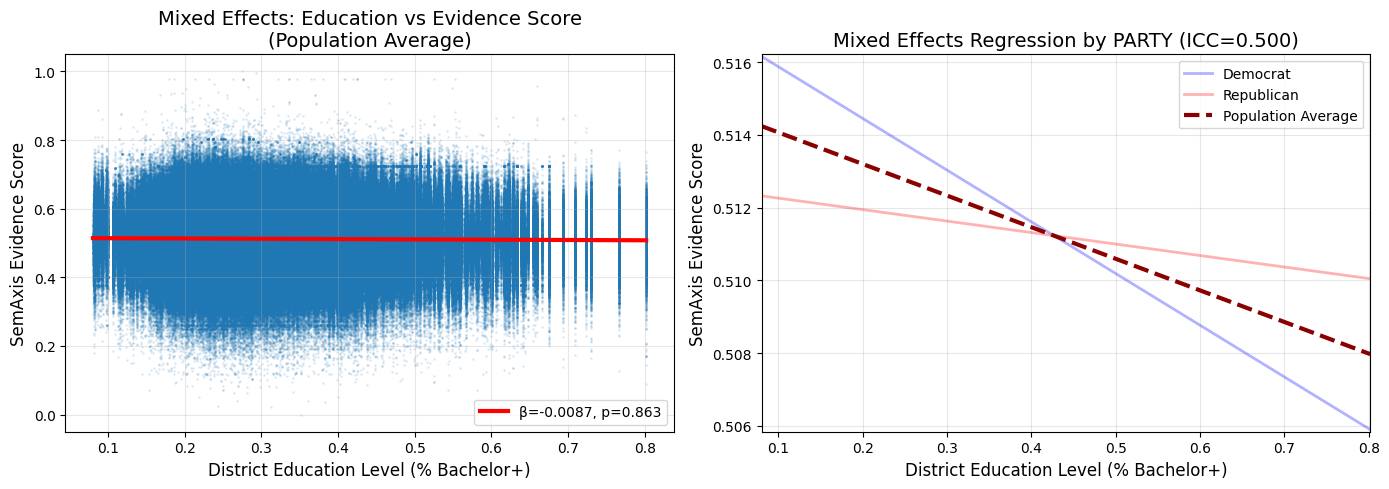

In [ ]:
mixed_effects_model(df, 'party', 'SemAxis')

Number of unique party combinations: 2


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



MIXED EFFECTS MODEL RESULTS FOR party
                        Mixed Linear Model Regression Results
Model:                     MixedLM           Dependent Variable:         bert_score  
No. Observations:          5458404           Method:                     REML        
No. Groups:                2                 Scale:                      0.0051      
Min. group size:           2196884           Log-Likelihood:             6643755.0608
Max. group size:           3261520           Converged:                  Yes         
Mean group size:           2729202.0                                                 
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.515    0.051 10.157 0.000  0.415  0.614
bachelors_or_higher_percentage         

/tmp/ipython-input-1850500497.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


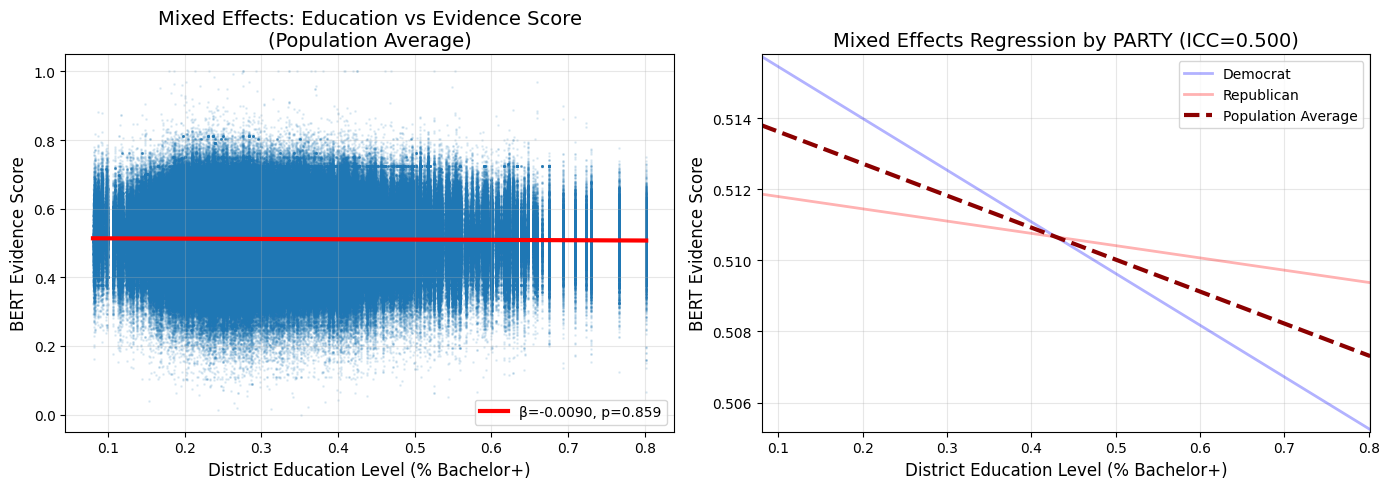

In [ ]:
mixed_effects_model(df, 'party', 'BERT')

Number of unique rep_id combinations: 853

MIXED EFFECTS MODEL RESULTS FOR rep_id
                        Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      semaxis_score_normalized
No. Observations:      5458404      Method:                  REML                    
No. Groups:            853          Scale:                   0.0048                  
Min. group size:       15           Log-Likelihood:          6814722.4635            
Max. group size:       57069        Converged:               Yes                     
Mean group size:       6399.1                                                        
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.493    0.006 88.057 0.000  0.482  0.

/tmp/ipython-input-4285055656.py:120: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


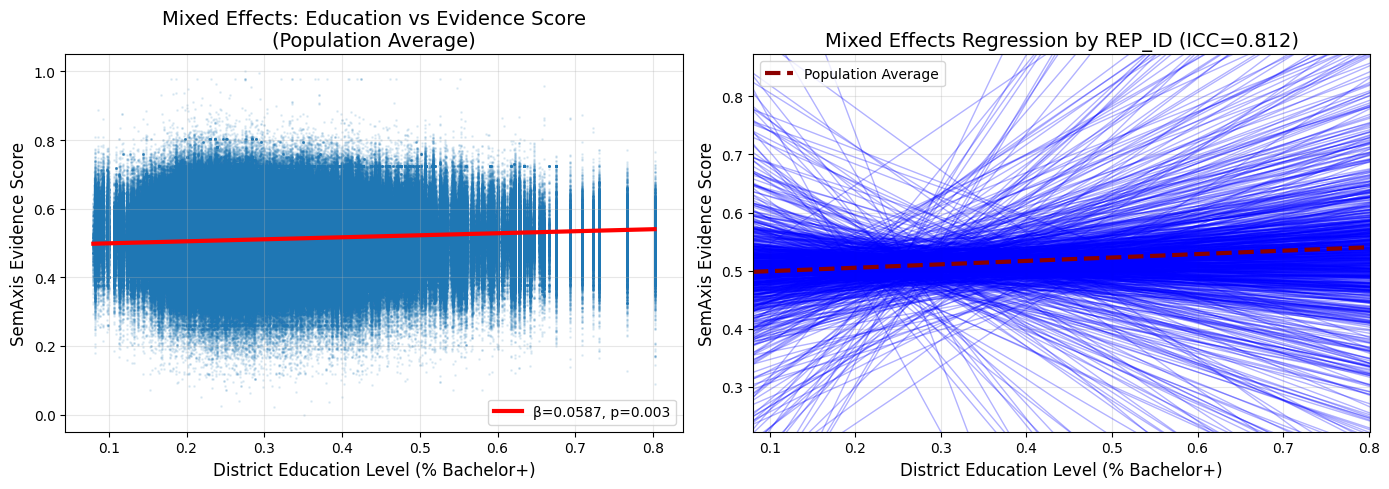

In [ ]:
mixed_effects_model(df, 'rep_id', 'SemAxis')

Number of unique rep_id combinations: 853

MIXED EFFECTS MODEL RESULTS FOR rep_id
                        Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          bert_score  
No. Observations:          5458404          Method:                      REML        
No. Groups:                853              Scale:                       0.0049      
Min. group size:           15               Log-Likelihood:              6777071.3821
Max. group size:           57069            Converged:                   Yes         
Mean group size:           6399.1                                                    
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.493    0.006 87.388 0.000  0.482  0.

/tmp/ipython-input-1850500497.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


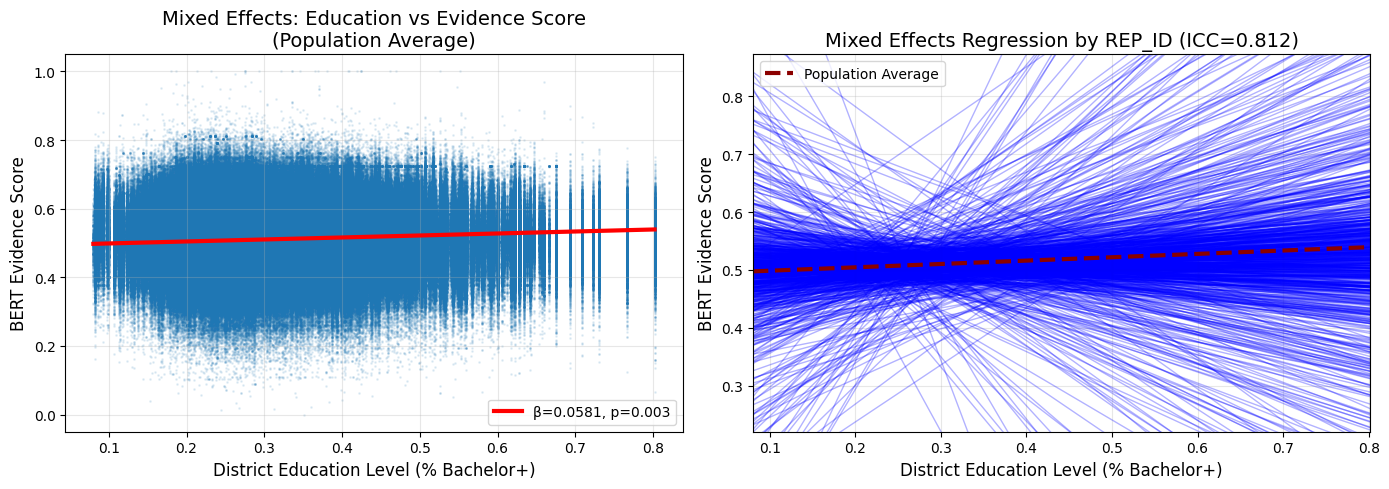

In [ ]:
mixed_effects_model(df, 'rep_id', 'BERT')